In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r", "human_VDss_L_kg", "human_CL_mL_min_kg"
                               ,"human_fup", "human_mrt", "human_thalf" ]]
human_inchi = human_lombardo[[ "smiles_r"]]
human_lombardo
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [9]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  2%|▋                                        | 21/1283 [00:01<01:32, 13.69it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 11%|████▎                                   | 138/1283 [00:09<00:54, 20.97it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 17%|██████▋                                 | 213/1283 [00:10<00:23, 44.92it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 20%|████████▏                               | 262/1283 [00:10<00:17, 57.58it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 26%|██████████▍                             | 336/1283 [00:11<00:11, 79.78it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|██████████▉                            | 360/1283 [00:11<00:07, 123.22it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▋                           | 407/1283 [00:13<00:26, 33.54it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 41%|████████████████                       | 527/1283 [00:14<00:07, 104.63it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 45%|█████████████████▍                     | 573/1283 [00:14<00:06, 110.18it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|██████████████████▍                     | 590/1283 [00:15<00:11, 58.79it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 48%|███████████████████▎                    | 619/1283 [00:16<00:11, 55.85it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 56%|██████████████████████▌                 | 722/1283 [00:18<00:09, 56.60it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|███████████████████████████▋            | 889/1283 [00:20<00:05, 73.53it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|██████████████████████████████▎       | 1022/1283 [00:21<00:02, 123.20it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████| 1283/1283 [00:23<00:00, 54.47it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_smiles_r['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [11]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [12]:
Mordred_table = Mordred_table.dropna(axis='columns')
selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Mordred_table = Mordred_table [selected_Features]
# Get correlation matrix and lower triangle of pairwise correlations in long format
data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
# Get absolute sum of correlation across features
# The lower the index, the less correlation to the full data frame
# We want to drop features with highest correlation, so drop higher index
variable_cor_sum = data_cor_df.abs().sum().sort_values().index
# And subset to only variable combinations that pass the threshold
pairwise_df = pairwise_df.query("correlation > 0.95")
excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
excluded_features = list(set(excluded.tolist()))
print(len(excluded_features))
new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)
max_feature_values = new_Mordred_table.max().abs()
min_feature_values = new_Mordred_table.min().abs()
#outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
#print(len(outlier_features))
#new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
new_Mordred_table['smiles_r'] = human_smiles_r['smiles_r']
new_Mordred_table

792
440


/tmp/ipykernel_661213/1936061042.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)


nAcid  nBase  SpDiam_A     VE1_A        VR1_A     VR3_A  nBridgehead  \
0       2.0    0.0  4.841033  4.403578  1234.924831  8.371528          0.0   
1       1.0    0.0  4.952581  3.888933   315.969458  6.544103          0.0   
2       4.0    0.0  4.898018  4.662066  1678.281927  8.786502          0.0   
3       0.0    1.0  4.453621  3.435097    62.887280  4.477816          0.0   
4       0.0    0.0  4.897943  3.720015   118.815845  5.419429          0.0   
...     ...    ...       ...       ...          ...       ...          ...   
1278    0.0    1.0  4.825894  3.671875    88.167036  4.949237          0.0   
1279    0.0    1.0  4.956344  3.727444   111.594288  5.302657          0.0   
1280    0.0    2.0  5.024986  3.573443   179.009256  5.880585          0.0   
1281    0.0    2.0  4.635214  4.106193   119.951796  5.480237          0.0   
1282    0.0    2.0  4.754235  3.668878    73.788606  4.706669          0.0   

      nHetero    nH   nN  ...  TopoPSA      GGI5     GGI10  Diameter  \
0        12.0  21.0  7.0  ...   212.96  1.236111  0.276400      19.0   
1         2.0  27.0  0.0  ...    40.13  1.861111  0.000000      10.0   
2        13.0  22.0  8.0  ...   169.30  1.628333  0.295078      20.0   
3         1.0  18.0  1.0  ...     4.44  0.229167  0.000000       9.0   
4         8.0  13.0  3.0  ...   130.83  0.837222  0.000000       9.0   
...       ...   ...  ...  ...      ...       ...       ...       ...   
1278      4.0  17.0  2.0  ...    38.31  0.173611  0.000000       8.0   
1279      1.0  26.0  1.0  ...     4.44  0.291667  0.000000       8.0   
1280      2.0  19.0  2.0  ...    26.00  0.242778  0.000000       8.0   
1281      3.0  20.0  3.0  ...    29.24  0.409722  0.000000       9.0   
1282      4.0  13.0  2.0  ...    44.46  0.263889  0.000000       8.0   

          MWC10     SRW09     TSRW10   WPath   mZagreb1  \
0     12.065505  0.000000  71.132315  4344.0  13.083333   
1     11.807615  0.000000  56.111877  1036.0  11.180556   
2     12.301215  6.259581  89.010877  5657.0  13.805556   
3     10.478217  0.000000  44.372474   337.0   5.333333   
4     11.940602  7.208600  67.418049   654.0   8.229167   
...         ...       ...        ...     ...        ...   
1278  11.416536  0.000000  48.647579   412.0   3.444444   
1279  11.710045  0.000000  51.418286   549.0   4.034722   
1280  12.334901  8.464003  75.593926   751.0   4.256944   
1281  11.281510  6.259581  66.060685   829.0   4.444444   
1282  11.305397  6.293419  60.402256   359.0   3.194444   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 353 columns]

In [13]:
human_lombardo_Mordred = pd.merge(human_lombardo, new_Mordred_table)
human_lombardo_Mordred
human_lombardo_Mordred.to_csv("Train_data_features.csv", index=False)

In [14]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']

In [15]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]
new_Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
new_Morganfingerprint_table

152


/tmp/ipykernel_661213/4098812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']


Mfp1  Mfp13  Mfp80  Mfp90  Mfp114  Mfp116  Mfp117  Mfp118  Mfp119  \
0        1      0      1      0       0       0       1       0       0   
1        0      0      1      0       1       0       0       0       0   
2        1      0      1      0       0       0       1       0       0   
3        1      0      1      0       0       0       0       0       0   
4        0      0      1      0       0       0       0       0       1   
...    ...    ...    ...    ...     ...     ...     ...     ...     ...   
1278     0      0      0      0       0       0       0       0       0   
1279     0      0      0      0       0       0       0       0       0   
1280     0      0      0      0       0       0       0       0       0   
1281     0      0      1      0       0       0       0       0       0   
1282     0      0      0      0       0       0       0       0       0   

      Mfp140  ...  Mfp1917  Mfp1921  Mfp1928  Mfp1970  Mfp1980  Mfp1991  \
0          0  ...        1        0        0        0        0        0   
1          0  ...        1        0        0        0        0        0   
2          0  ...        1        0        1        0        0        1   
3          0  ...        0        0        0        0        0        0   
4          0  ...        0        1        0        0        0        0   
...      ...  ...      ...      ...      ...      ...      ...      ...   
1278       0  ...        0        0        0        0        0        0   
1279       0  ...        0        0        0        0        0        0   
1280       0  ...        0        0        0        0        0        0   
1281       0  ...        0        1        0        0        0        0   
1282       0  ...        0        0        0        0        0        0   

      Mfp2010  Mfp2031  Mfp2038  \
0           0        0        0   
1           0        0        0   
2           0        0        0   
3           0        1        0   
4           0        0        0   
...       ...      ...      ...   
1278        0        0        0   
1279        0        0        0   
1280        0        0        0   
1281        0        0        0   
1282        0        0        0   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 153 columns]

In [16]:
Mordred_columns = new_Mordred_table.columns[:-1].tolist()
mfp_columns = new_Morganfingerprint_table.columns[:-1].tolist()
#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mfp_mordred_columns = Mordred_columns + mfp_columns
print(len(features_mfp_mordred_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_columns_human.txt", "w")
for item in features_mfp_mordred_columns:
   f.write(item + "\n")
f.close()

504


In [17]:
#read from file
file = open("features_mfp_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]
features_mfp_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR1_A',
 'VR3_A',
 'nBridgehead',
 'nHetero',
 'nH',
 'nN',
 'nO',
 'nS',
 'nP',
 'nF',
 'nX',
 'ATS0dv',
 'ATS4dv',
 'ATS2s',
 'ATS4s',
 'ATS4m',
 'ATS5i',
 'ATS8i',
 'AATS1dv',
 'AATS2dv',
 'AATS3dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS0s',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS1m',
 'AATS3m',
 'AATS1v',
 'AATS3v',
 'AATS1are',
 'AATS2are',
 'AATS3are',
 'AATS0p',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC2Z',
 'ATSC5Z',
 'ATSC6Z',
 'ATSC0m',
 'ATSC3m',
 'ATSC4m',
 'ATSC7m',
 'ATSC8m',
 'ATSC1v',
 'ATSC2v',
 'ATSC3v',
 'ATSC4v',
 'ATSC5v',
 'ATSC6v',
 

In [18]:
human_lombardo_mfp = pd.merge(human_lombardo, new_Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, new_Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp1  Mfp13  \
0               0.638489       0.33   0.568202     1.176091     1      0   
1               0.949390        NaN   1.348305     1.705008     0      0   
2              -0.537602       0.01   1.482588     1.894870     1      0   
3               1.301030       0.13   0.204120     0.113943     1      0   
4               0.204120        NaN   1.068186     1.037426     0      0   
...                  ...        ...        ...          ...   ...    ...   
1278            0.903090        NaN   1.021189     0.913814     0      0   
1279            0.707570       0.35   1.361728     1.204120     0      0   
1280            0.934498       0.50   0.892095     0.863323     0      0   
1281            1.293804        NaN   0.537819     0.359835     0      0   
1282            1.000000        NaN   0.740363     0.623249     0      0   

      Mfp80  Mfp90  ...    SLogP  TopoPSA      GGI5     GGI10  Diameter  \
0         1      0  ... -1.68780   212.96  1.236111  0.276400      19.0   
1         1      0  ...  4.34140    40.13  1.861111  0.000000      10.0   
2         1      0  ... -0.42876   169.30  1.628333  0.295078      20.0   
3         1      0  ...  0.76550     4.44  0.229167  0.000000       9.0   
4         1      0  ... -2.55960   130.83  0.837222  0.000000       9.0   
...     ...    ...  ...      ...      ...       ...       ...       ...   
1278      0      0  ... -0.15880    38.31  0.173611  0.000000       8.0   
1279      0      0  ...  2.91480     4.44  0.291667  0.000000       8.0   
1280      0      0  ...  1.07490    26.00  0.242778  0.000000       8.0   
1281      1      0  ...  0.77550    29.24  0.409722  0.000000       9.0   
1282      0      0  ... -1.09130    44.46  0.263889  0.000000       8.0   

          MWC10     SRW09     TSRW10   WPath   mZagreb1  
0     12.065505  0.000000  71.132315  4344.0  13.083333  
1     11.807615  0.000000  56.111877  1036.0  11.180556  
2     12.301215  6.259581  89.010877  5657.0  13.805556  
3     10.478217  0.000000  44.372474   337.0   5.333333  
4     11.940602  7.208600  67.418049   654.0   8.229167  
...         ...       ...        ...     ...        ...  
1278  11.416536  0.000000  48.647579   412.0   3.444444  
1279  11.710045  0.000000  51.418286   549.0   4.034722  
1280  12.334901  8.464003  75.593926   751.0   4.256944  
1281  11.281510  6.259581  66.060685   829.0   4.444444  
1282  11.305397  6.293419  60.402256   359.0   3.194444  

[1283 rows x 510 columns]

In [19]:
human_lombardo_mfp_Mordred.to_csv("./Train_data_features.csv", index=False)

In [20]:
human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp1  Mfp13  \
0               0.638489       0.33   0.568202     1.176091     1      0   
1               0.949390        NaN   1.348305     1.705008     0      0   
2              -0.537602       0.01   1.482588     1.894870     1      0   
3               1.301030       0.13   0.204120     0.113943     1      0   
4               0.204120        NaN   1.068186     1.037426     0      0   
...                  ...        ...        ...          ...   ...    ...   
1278            0.903090        NaN   1.021189     0.913814     0      0   
1279            0.707570       0.35   1.361728     1.204120     0      0   
1280            0.934498       0.50   0.892095     0.863323     0      0   
1281            1.293804        NaN   0.537819     0.359835     0      0   
1282            1.000000        NaN   0.740363     0.623249     0      0   

      Mfp80  Mfp90  ...    SLogP  TopoPSA      GGI5     GGI10  Diameter  \
0         1      0  ... -1.68780   212.96  1.236111  0.276400      19.0   
1         1      0  ...  4.34140    40.13  1.861111  0.000000      10.0   
2         1      0  ... -0.42876   169.30  1.628333  0.295078      20.0   
3         1      0  ...  0.76550     4.44  0.229167  0.000000       9.0   
4         1      0  ... -2.55960   130.83  0.837222  0.000000       9.0   
...     ...    ...  ...      ...      ...       ...       ...       ...   
1278      0      0  ... -0.15880    38.31  0.173611  0.000000       8.0   
1279      0      0  ...  2.91480     4.44  0.291667  0.000000       8.0   
1280      0      0  ...  1.07490    26.00  0.242778  0.000000       8.0   
1281      1      0  ...  0.77550    29.24  0.409722  0.000000       9.0   
1282      0      0  ... -1.09130    44.46  0.263889  0.000000       8.0   

          MWC10     SRW09     TSRW10   WPath   mZagreb1  
0     12.065505  0.000000  71.132315  4344.0  13.083333  
1     11.807615  0.000000  56.111877  1036.0  11.180556  
2     12.301215  6.259581  89.010877  5657.0  13.805556  
3     10.478217  0.000000  44.372474   337.0   5.333333  
4     11.940602  7.208600  67.418049   654.0   8.229167  
...         ...       ...        ...     ...        ...  
1278  11.416536  0.000000  48.647579   412.0   3.444444  
1279  11.710045  0.000000  51.418286   549.0   4.034722  
1280  12.334901  8.464003  75.593926   751.0   4.256944  
1281  11.281510  6.259581  66.060685   829.0   4.444444  
1282  11.305397  6.293419  60.402256   359.0   3.194444  

[1283 rows x 510 columns]

human_VDss_L_kg
0
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  54.0
3-fold :  75.6
5-fold :  88.4
gmfe :  2.1859964894132173
mfe :  1.296508673804885
bias :  0.021020705983256047
rmse  0.4509310931050869
r2  0.5287258993493784
saving model


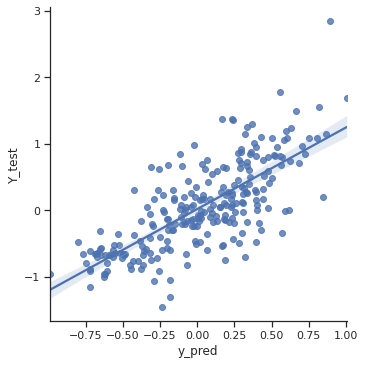

1
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  59.599999999999994
3-fold :  76.0
5-fold :  89.2
gmfe :  2.0707952072407987
mfe :  1.257175806358395
bias :  0.07994839899759727
rmse  0.41442408865521985
r2  0.539974558403981
saving model


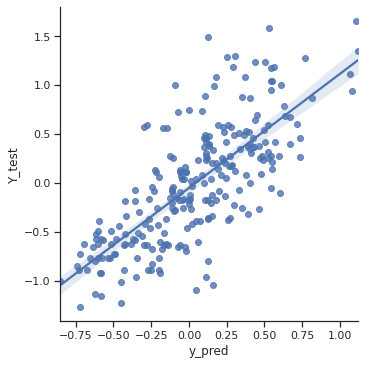

2
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
250
2-fold :  54.400000000000006
3-fold :  74.0
5-fold :  86.4
gmfe :  2.2337246061901106
mfe :  1.2970982693869024
bias :  0.009444557402730855
rmse  0.48152921467482424
r2  0.4661990291536158


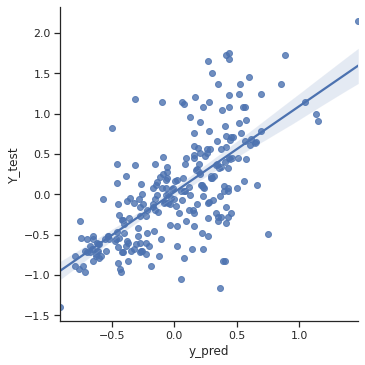

3
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  59.599999999999994
3-fold :  72.8
5-fold :  88.0
gmfe :  2.1149386078263492
mfe :  1.2630849474288968
bias :  0.015340071687508783
rmse  0.43080005743078
r2  0.5568572928305164


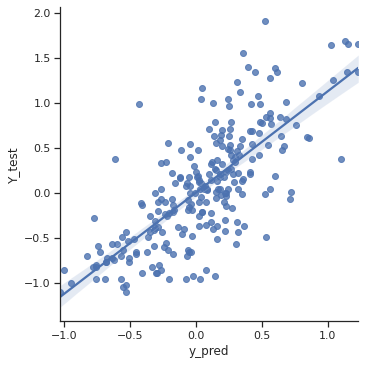

4
(1000, 504)
(249, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
249
2-fold :  53.01204819277109
3-fold :  74.29718875502009
5-fold :  90.36144578313254
gmfe :  2.221393093515935
mfe :  1.3115386715567647
bias :  0.07141997531541897
rmse  0.4540131725521264
r2  0.4657468774924326


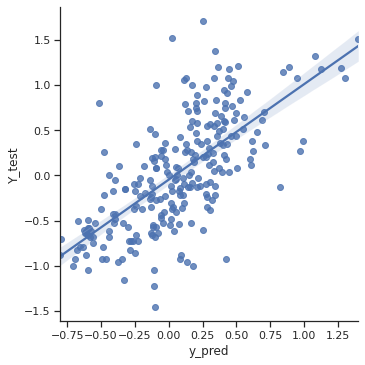

0
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
250
2-fold :  57.599999999999994
3-fold :  74.0
5-fold :  88.0
gmfe :  2.134360709782056
mfe :  1.2668924511107091
bias :  0.054922196079566346
rmse  0.4305551268193451
r2  0.49250686140407374


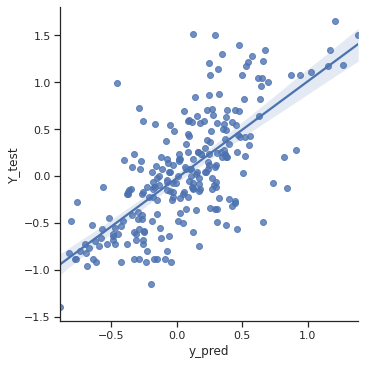

1
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
250
2-fold :  54.400000000000006
3-fold :  71.6
5-fold :  86.0
gmfe :  2.3023254202771803
mfe :  1.3081082620903148
bias :  0.0025973468878574685
rmse  0.47601467948644866
r2  0.5072956862343686


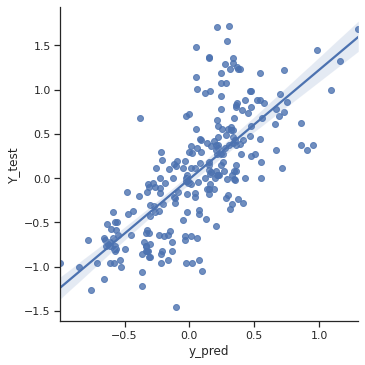

2
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  58.4
3-fold :  75.6
5-fold :  89.60000000000001
gmfe :  2.1246583649316806
mfe :  1.2691392790634541
bias :  0.021646683702058966
rmse  0.44629120496878005
r2  0.49285684075268654


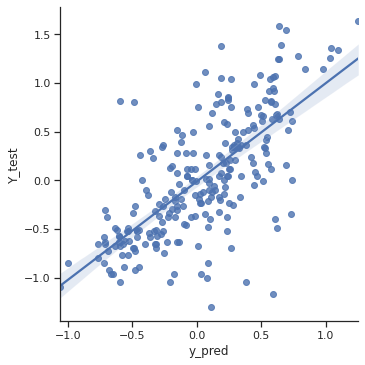

3
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
250
2-fold :  59.199999999999996
3-fold :  78.0
5-fold :  90.4
gmfe :  2.0545551124426153
mfe :  1.2714591494120089
bias :  0.019998193501412825
rmse  0.43018502475267917
r2  0.5438027521428896
saving model


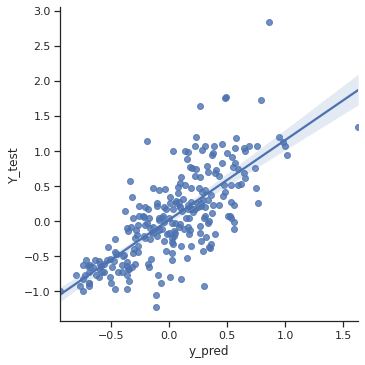

4
(1000, 504)
(249, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
249
2-fold :  53.81526104417671
3-fold :  72.28915662650603
5-fold :  89.95983935742971
gmfe :  2.131797390899643
mfe :  1.2895198226319982
bias :  0.02673012717045764
rmse  0.43841486334416196
r2  0.5432424117882821


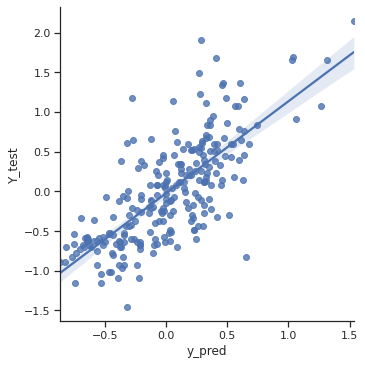

0
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  54.0
3-fold :  73.2
5-fold :  86.4
gmfe :  2.207856898696268
mfe :  1.2986518048745266
bias :  0.010472178776463774
rmse  0.46333624300268916
r2  0.4754744030747281


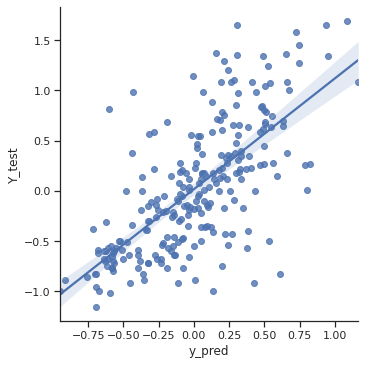

1
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
250
2-fold :  54.800000000000004
3-fold :  74.4
5-fold :  88.0
gmfe :  2.22447395065798
mfe :  1.297905178343313
bias :  0.04659370268002212
rmse  0.4593455400915156
r2  0.5343759877569704


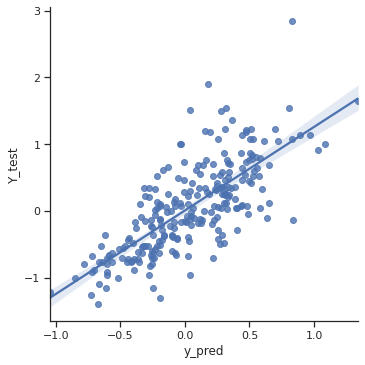

2
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  54.0
3-fold :  69.6
5-fold :  88.4
gmfe :  2.2003606401928635
mfe :  1.313091720779831
bias :  0.03244262945846174
rmse  0.446771206485008
r2  0.5222804023598363


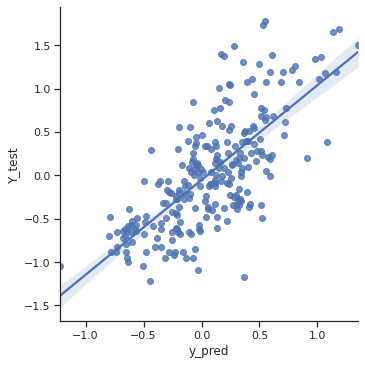

3
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
250
2-fold :  57.599999999999994
3-fold :  76.0
5-fold :  90.8
gmfe :  2.093177453742774
mfe :  1.3107452270273998
bias :  0.043627559464733706
rmse  0.4223101338201014
r2  0.5103668860903912


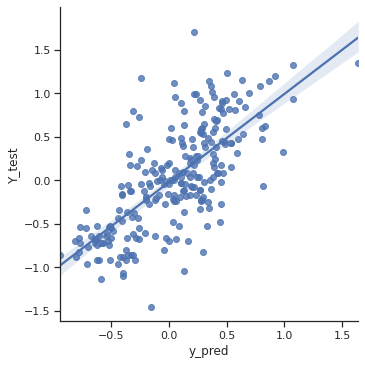

4
(1000, 504)
(249, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
249
2-fold :  61.84738955823293
3-fold :  80.32128514056225
5-fold :  90.76305220883533
gmfe :  2.044059475274299
mfe :  1.2627205700230442
bias :  -0.004823299586103419
rmse  0.4147652228214092
r2  0.5716172177033889
saving model


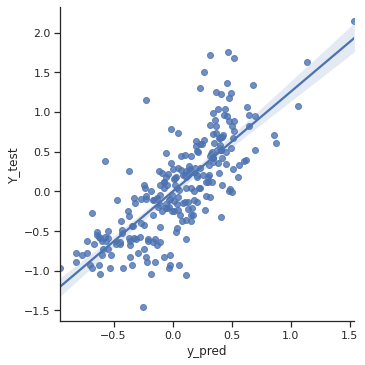

0
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  57.99999999999999
3-fold :  74.4
5-fold :  88.4
gmfe :  2.191938411074886
mfe :  1.2866415502606061
bias :  0.007139267515088629
rmse  0.46637503180885764
r2  0.4744282489555255


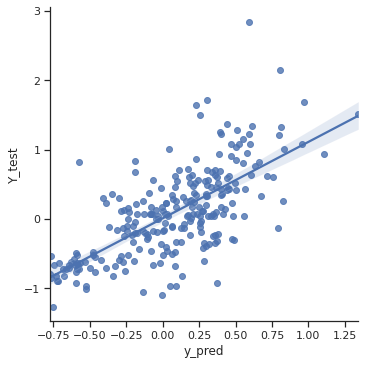

1
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
250
2-fold :  57.99999999999999
3-fold :  76.4
5-fold :  89.2
gmfe :  2.0633448896919004
mfe :  1.2570722728059789
bias :  0.022189326056560113
rmse  0.42165112049171716
r2  0.49617850158588306


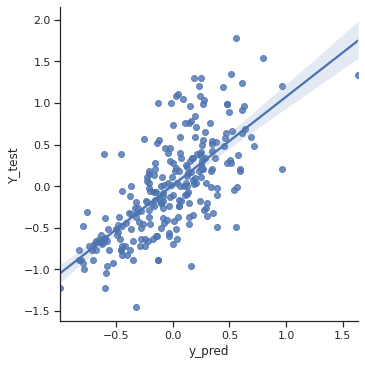

2
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
250
2-fold :  55.60000000000001
3-fold :  74.0
5-fold :  88.0
gmfe :  2.2789509225060076
mfe :  1.2945410145867224
bias :  0.0165393840071004
rmse  0.4771740824449702
r2  0.5014031991969012


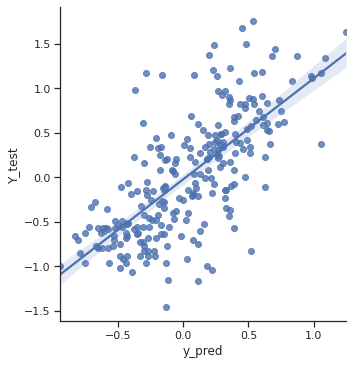

3
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  53.6
3-fold :  74.4
5-fold :  88.8
gmfe :  2.173412068991894
mfe :  1.3089083607466905
bias :  0.11661706178470421
rmse  0.4381288187709057
r2  0.5129246223958094


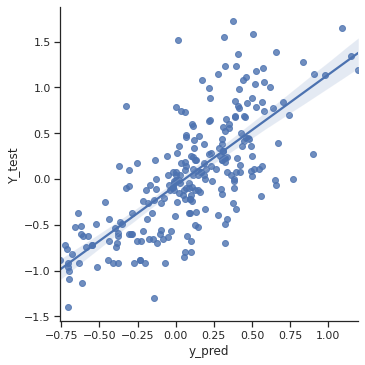

4
(1000, 504)
(249, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
249
2-fold :  59.036144578313255
3-fold :  76.30522088353415
5-fold :  91.96787148594377
gmfe :  2.063286645719518
mfe :  1.2697747879943095
bias :  0.05815170972116035
rmse  0.41141034689539385
r2  0.6002588565266379


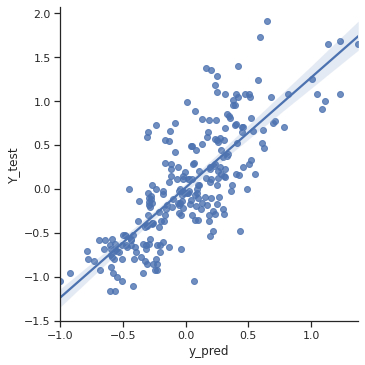

0
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
250
2-fold :  54.800000000000004
3-fold :  76.0
5-fold :  88.4
gmfe :  2.1850029068246988
mfe :  1.2857676112138845
bias :  0.029231588218599613
rmse  0.44146999801958
r2  0.5006905957867143


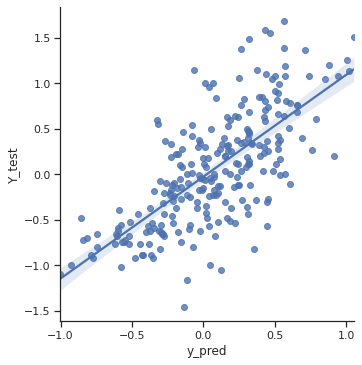

1
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  57.99999999999999
3-fold :  76.4
5-fold :  90.8
gmfe :  2.1227663997340316
mfe :  1.2837438526433698
bias :  0.07061759607334298
rmse  0.43765212633479544
r2  0.5477121449742874


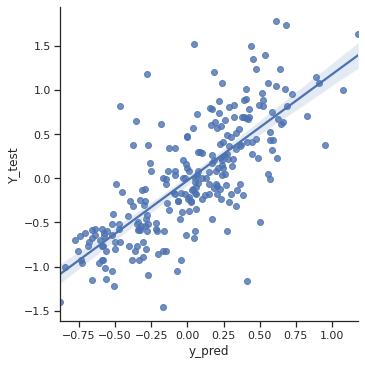

2
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
250
2-fold :  59.599999999999994
3-fold :  74.4
5-fold :  89.60000000000001
gmfe :  2.0899405063686243
mfe :  1.2578985512536525
bias :  0.020124713611201606
rmse  0.433162891733938
r2  0.5374542809543998


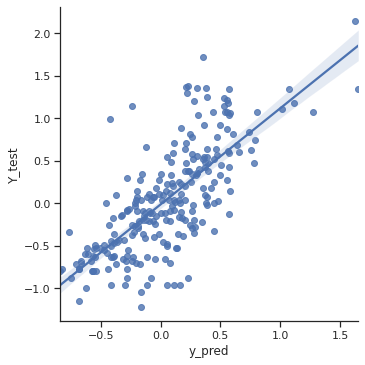

3
(999, 504)
(250, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
250
2-fold :  54.400000000000006
3-fold :  73.2
5-fold :  90.8
gmfe :  2.1866916179315017
mfe :  1.3012545215806297
bias :  -0.0172367682737459
rmse  0.4404370905730186
r2  0.5426476755852279


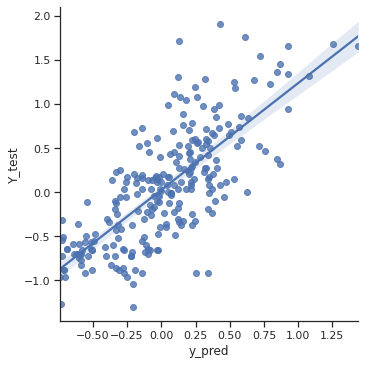

4
(1000, 504)
(249, 504)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
249
2-fold :  57.42971887550201
3-fold :  77.10843373493977
5-fold :  89.95983935742971
gmfe :  2.144533247821075
mfe :  1.2940078770571541
bias :  0.05304944197757197
rmse  0.43983566444016803
r2  0.5174715021773146


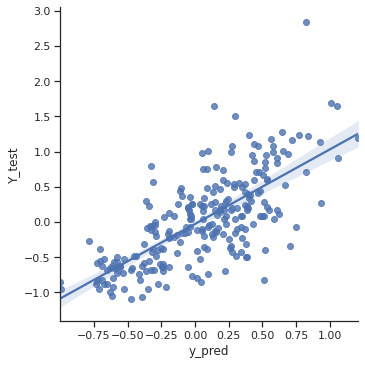

human_CL_mL_min_kg
0
(1024, 504)
(257, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
257
2-fold :  48.249027237354085
3-fold :  71.98443579766537
5-fold :  83.65758754863813
gmfe :  2.584894253467918
mfe :  1.3595794540002952
bias :  0.021183073803247243
rmse  0.5746953314889124
r2  0.27580495889078005
saving model


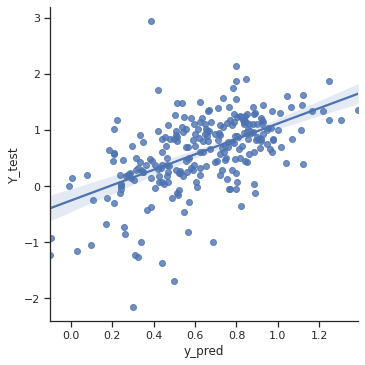

1
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
256
2-fold :  49.609375
3-fold :  73.046875
5-fold :  84.765625
gmfe :  2.4520420575991984
mfe :  1.3538244047324854
bias :  -0.40770489169570034
rmse  0.5297628467108888
r2  0.3091593910906705
saving model


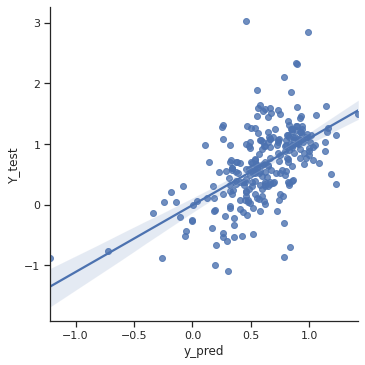

2
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
256
2-fold :  52.34375
3-fold :  73.046875
5-fold :  83.984375
gmfe :  2.456932910492172
mfe :  1.3240294369432692
bias :  -0.45758110025573795
rmse  0.5229886074920744
r2  0.24221510687073977


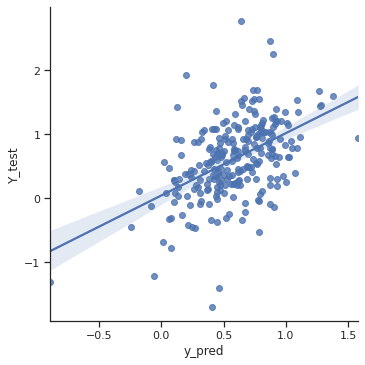

3
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  50.78125
3-fold :  67.578125
5-fold :  86.328125
gmfe :  2.4792126111563433
mfe :  1.3330317217996384
bias :  -0.47910080974017766
rmse  0.5339821190608632
r2  0.34095354283208046


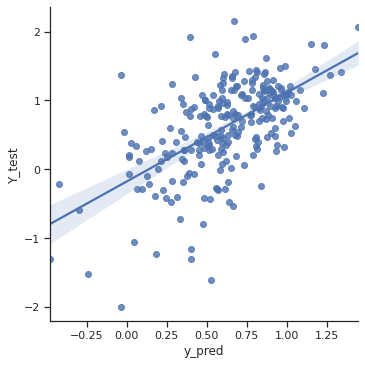

4
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  50.0
3-fold :  67.96875
5-fold :  81.25
gmfe :  2.6928312614026972
mfe :  1.3523738708342197
bias :  0.10389747886093048
rmse  0.6048261834129935
r2  0.18277997865751183


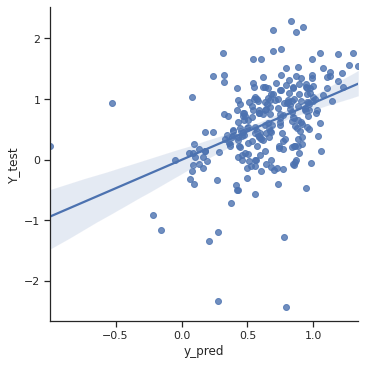

0
(1024, 504)
(257, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
257
2-fold :  51.36186770428015
3-fold :  65.36964980544747
5-fold :  82.10116731517509
gmfe :  2.669188677080485
mfe :  1.32488930656932
bias :  0.02907940662580355
rmse  0.6082859111500615
r2  0.27012555973658203


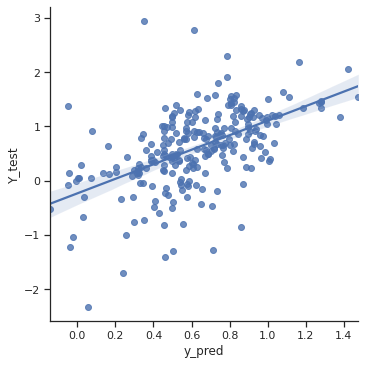

1
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
256
2-fold :  41.40625
3-fold :  65.625
5-fold :  82.03125
gmfe :  2.8426335580583095
mfe :  1.4177234449475373
bias :  -0.5277952228249105
rmse  0.607436284863201
r2  0.262713530130929


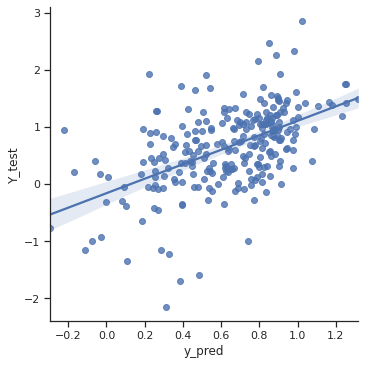

2
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
256
2-fold :  49.21875
3-fold :  70.3125
5-fold :  84.375
gmfe :  2.4501446318388926
mfe :  1.3673870144247302
bias :  -0.39102515854492914
rmse  0.5106138510563225
r2  0.27847249112035555
saving model


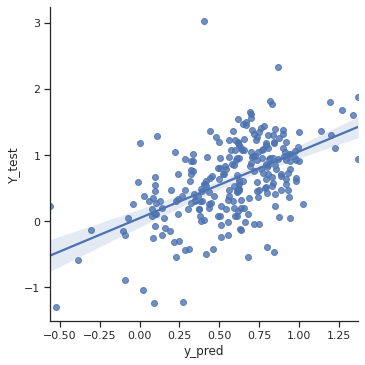

3
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=43)
256
2-fold :  48.828125
3-fold :  73.4375
5-fold :  87.890625
gmfe :  2.4219005174897825
mfe :  1.365133674001553
bias :  -0.40612315558257883
rmse  0.506546301813766
r2  0.29574775405984266
saving model


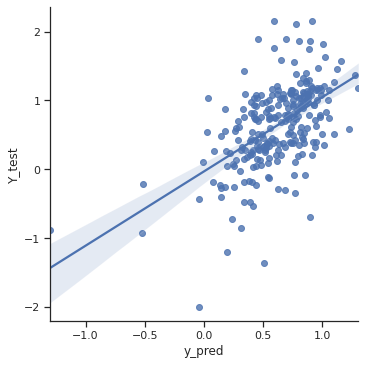

4
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
256
2-fold :  54.296875
3-fold :  71.875
5-fold :  86.71875
gmfe :  2.298421026133544
mfe :  1.3180642036391947
bias :  -0.20898682673961244
rmse  0.49798441519075903
r2  0.32971045281203293
saving model


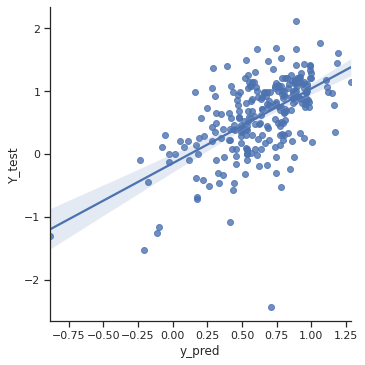

0
(1024, 504)
(257, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
257
2-fold :  50.97276264591439
3-fold :  72.37354085603113
5-fold :  87.93774319066148
gmfe :  2.3732965500753225
mfe :  1.3367344706868183
bias :  -0.2909905126282961
rmse  0.5091581939155063
r2  0.3587090390020212


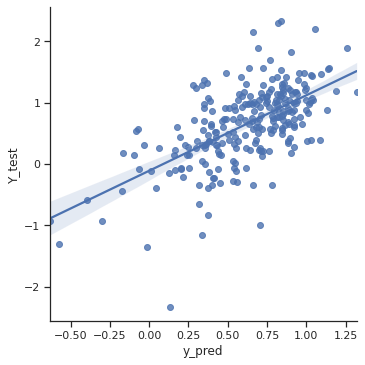

1
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  52.34375
3-fold :  72.265625
5-fold :  89.0625
gmfe :  2.3877540564960453
mfe :  1.314467300973014
bias :  -0.5726536406744664
rmse  0.5244914908399826
r2  0.30245273089251457


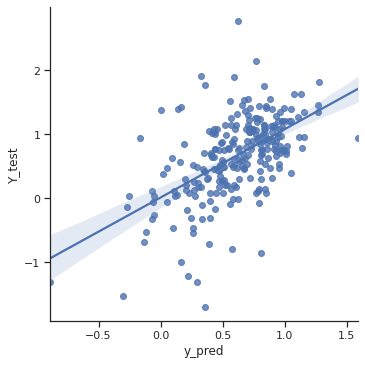

2
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
256
2-fold :  50.390625
3-fold :  69.53125
5-fold :  83.59375
gmfe :  2.5905252747651937
mfe :  1.3449645398848313
bias :  0.32720834466240845
rmse  0.5600443860481142
r2  0.3065588735739354


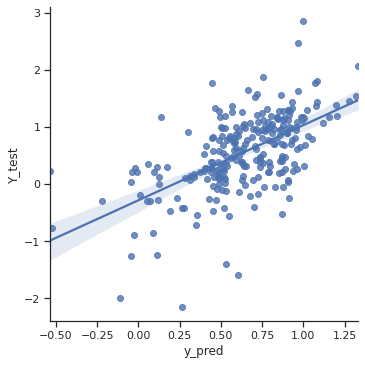

3
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  49.21875
3-fold :  65.234375
5-fold :  82.03125
gmfe :  2.7045443738903825
mfe :  1.3778594323349536
bias :  -0.11390270139310582
rmse  0.6011333946756237
r2  0.21059673304601767


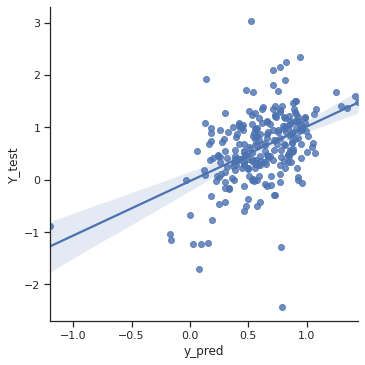

4
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
256
2-fold :  48.828125
3-fold :  67.578125
5-fold :  82.8125
gmfe :  2.4649477373645428
mfe :  1.3684042718477982
bias :  -0.43759975851148236
rmse  0.52755283231724
r2  0.28288897474494734


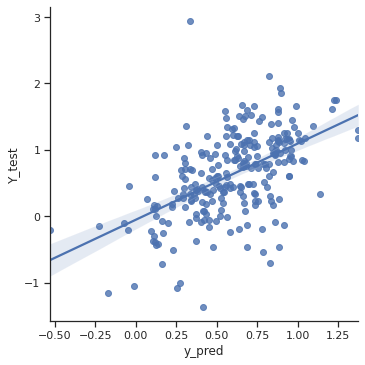

0
(1024, 504)
(257, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
257
2-fold :  45.13618677042802
3-fold :  71.98443579766537
5-fold :  87.93774319066148
gmfe :  2.3741319649144876
mfe :  1.3864056959968587
bias :  -0.4821190847403125
rmse  0.4727939748284337
r2  0.3288807389262606


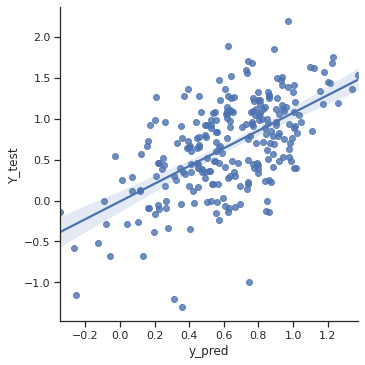

1
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  47.65625
3-fold :  69.921875
5-fold :  84.375
gmfe :  2.425043115384468
mfe :  1.3641195174234442
bias :  0.17854452239061086
rmse  0.49989878154035455
r2  0.3301128978749672


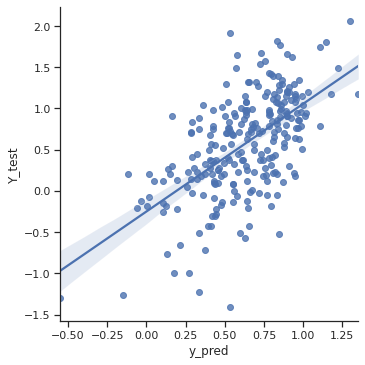

2
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
256
2-fold :  50.390625
3-fold :  70.703125
5-fold :  83.984375
gmfe :  2.5914131000802643
mfe :  1.346561482347298
bias :  -0.8646755716056285
rmse  0.5850287942329883
r2  0.23031260822448962


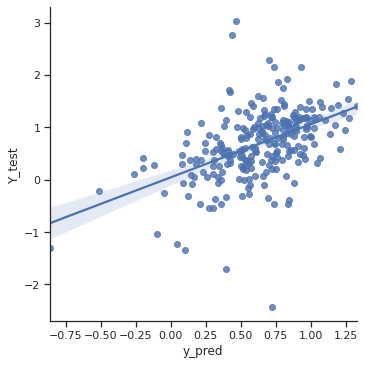

3
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  54.6875
3-fold :  70.3125
5-fold :  84.375
gmfe :  2.4796226438649867
mfe :  1.312428404114722
bias :  -0.1683542611737509
rmse  0.5511170222319681
r2  0.25869250981165837


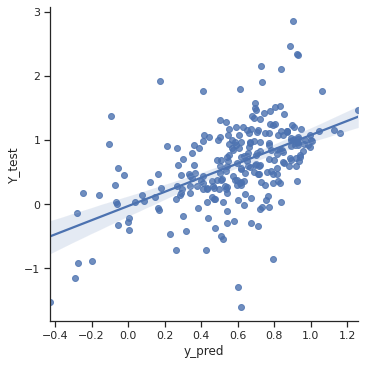

4
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  50.390625
3-fold :  68.75
5-fold :  82.8125
gmfe :  2.6720993107903186
mfe :  1.348742630637369
bias :  -0.1966146806051028
rmse  0.606092774995898
r2  0.31017902767699856


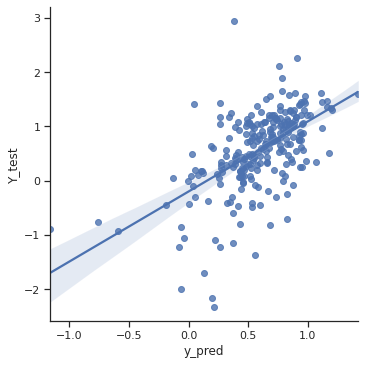

0
(1024, 504)
(257, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
257
2-fold :  51.75097276264592
3-fold :  70.03891050583657
5-fold :  84.43579766536965
gmfe :  2.4809222010894407
mfe :  1.319286038409773
bias :  -0.7817988280311878
rmse  0.5577667853704311
r2  0.22746613396774262


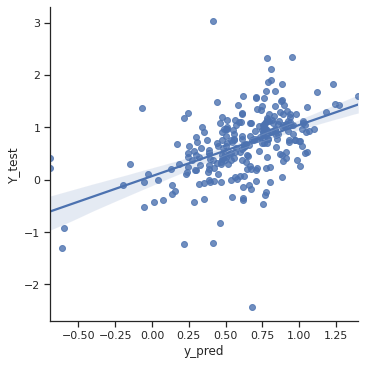

1
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
256
2-fold :  45.703125
3-fold :  64.84375
5-fold :  82.03125
gmfe :  2.7580035020619174
mfe :  1.3977774946949602
bias :  -0.16210119130306966
rmse  0.5964314117531162
r2  0.3064468952622462


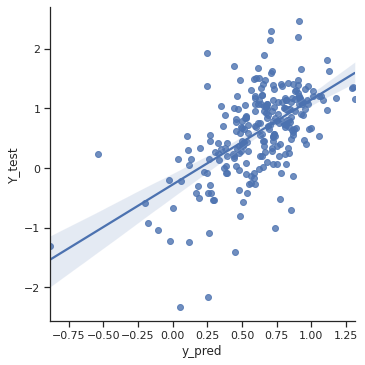

2
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
256
2-fold :  54.296875
3-fold :  70.703125
5-fold :  82.421875
gmfe :  2.512262275936155
mfe :  1.3213341537896601
bias :  0.2270059485308229
rmse  0.5655794184785033
r2  0.27194157092548543


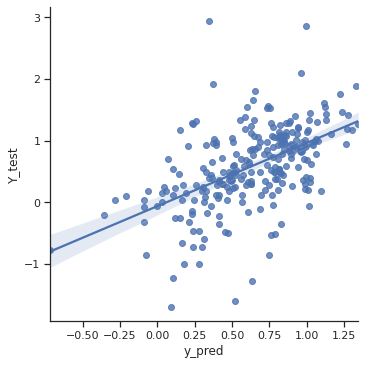

3
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
256
2-fold :  45.3125
3-fold :  69.140625
5-fold :  85.15625
gmfe :  2.519594995840492
mfe :  1.3787896270711548
bias :  -0.040280497226209244
rmse  0.5290250476364237
r2  0.3292793639374477


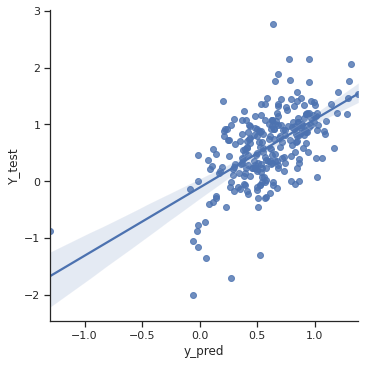

4
(1025, 504)
(256, 504)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
256
2-fold :  50.78125
3-fold :  75.78125
5-fold :  89.453125
gmfe :  2.2471854191904077
mfe :  1.3416688237773937
bias :  -0.32199682079554387
rmse  0.4597345571075883
r2  0.3552725427319031
saving model


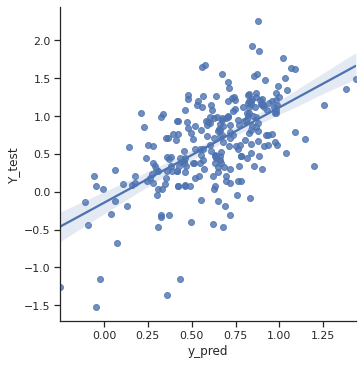

human_fup
0
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
176
2-fold :  52.84090909090909
3-fold :  62.5
5-fold :  72.1590909090909
gmfe :  3.2126566939008256
mfe :  1.3077078767060095
bias :  0.05118346003084199
rmse  0.2176314025379345
r2  0.6161543569119271
saving model


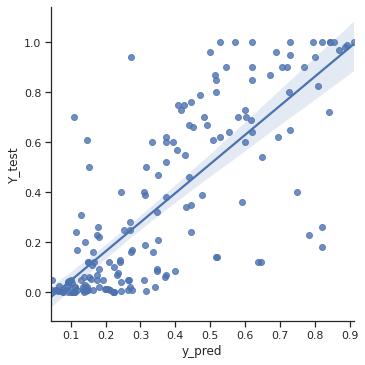

1
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
176
2-fold :  53.97727272727273
3-fold :  68.75
5-fold :  78.97727272727273
gmfe :  2.846414479130698
mfe :  1.3179621723631236
bias :  0.054474832818985235
rmse  0.20628316885953035
r2  0.5800377993652268
saving model


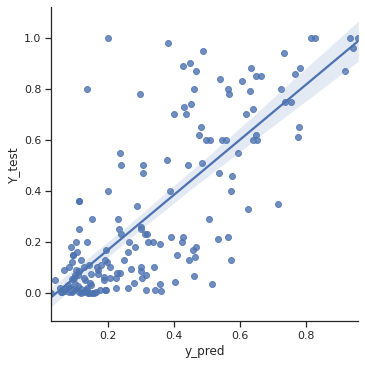

2
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
176
2-fold :  57.38636363636363
3-fold :  68.75
5-fold :  82.38636363636364
gmfe :  2.611501441429797
mfe :  1.2500888204050316
bias :  -0.0010649595407715012
rmse  0.24310621927117107
r2  0.5081083811709224
saving model


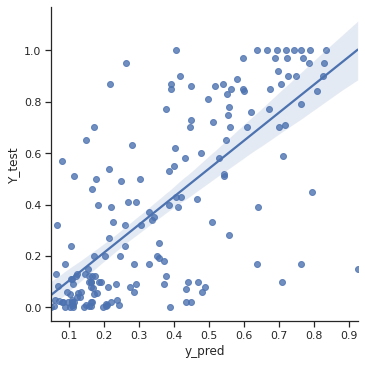

3
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
176
2-fold :  51.70454545454546
3-fold :  64.20454545454545
5-fold :  77.8409090909091
gmfe :  2.861296099352942
mfe :  1.3191418120845406
bias :  0.04855250097553647
rmse  0.22815982840322332
r2  0.5659262474988525


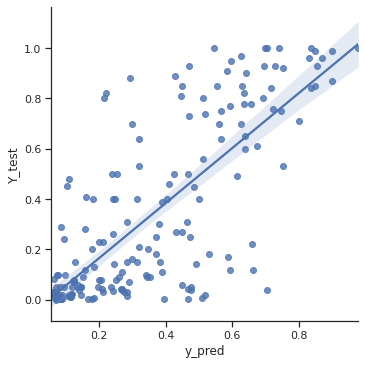

4
(704, 504)
(175, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
175
2-fold :  57.14285714285714
3-fold :  65.71428571428571
5-fold :  74.85714285714286
gmfe :  2.873677035386554
mfe :  1.2724958982638126
bias :  0.05228029334391571
rmse  0.21131102124201975
r2  0.6042138975760586


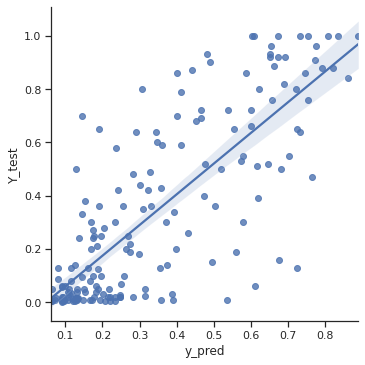

0
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
176
2-fold :  52.27272727272727
3-fold :  64.77272727272727
5-fold :  78.4090909090909
gmfe :  2.7924721378102033
mfe :  1.311307546951087
bias :  0.051242780821531886
rmse  0.23121459109494047
r2  0.5343022988185635


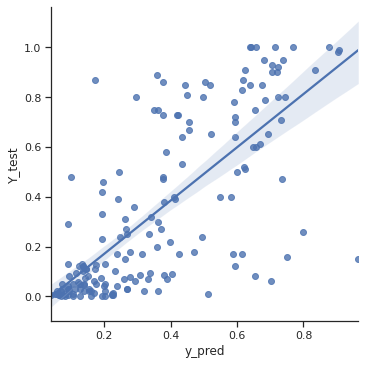

1
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  57.95454545454546
3-fold :  64.20454545454545
5-fold :  77.27272727272727
gmfe :  2.8357845566157867
mfe :  1.2520838522351423
bias :  0.03221322871325938
rmse  0.20494666892347746
r2  0.5929179823008037


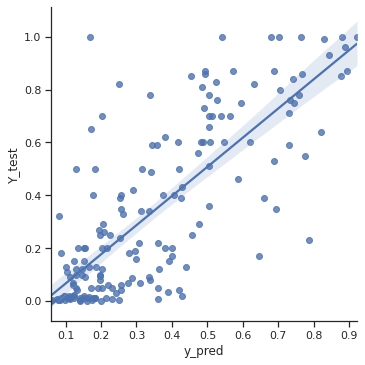

2
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
176
2-fold :  53.40909090909091
3-fold :  66.47727272727273
5-fold :  76.13636363636364
gmfe :  3.178012855706429
mfe :  1.2922161870998476
bias :  0.037260031027403925
rmse  0.23269732246786715
r2  0.6029375977055412


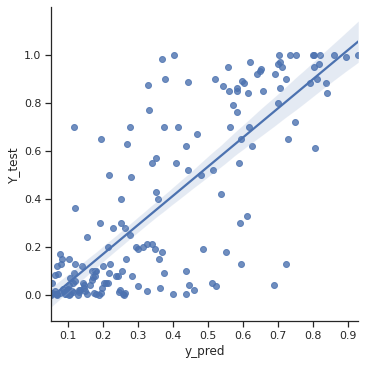

3
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  54.54545454545454
3-fold :  66.47727272727273
5-fold :  77.27272727272727
gmfe :  3.0261553255083453
mfe :  1.3128780877568482
bias :  0.04023527138287996
rmse  0.24870007886397896
r2  0.5123995766712718


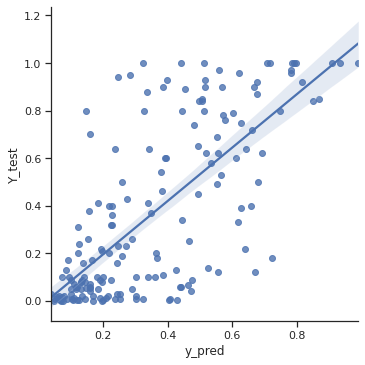

4
(704, 504)
(175, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=43)
175
2-fold :  54.85714285714286
3-fold :  66.28571428571428
5-fold :  79.42857142857143
gmfe :  2.5499660807570383
mfe :  1.291635880198354
bias :  0.044904695977360916
rmse  0.19350793595443944
r2  0.6174925127315648
saving model


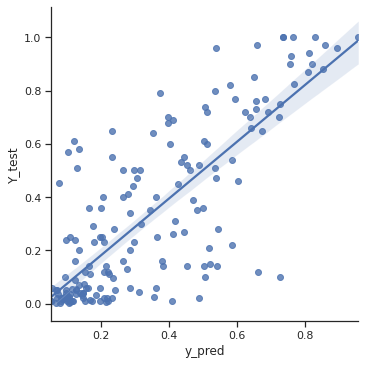

0
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
176
2-fold :  56.25
3-fold :  68.18181818181817
5-fold :  81.81818181818183
gmfe :  2.5703840729439142
mfe :  1.286010990927959
bias :  0.040263690698067484
rmse  0.21390163735871112
r2  0.6247430087225603


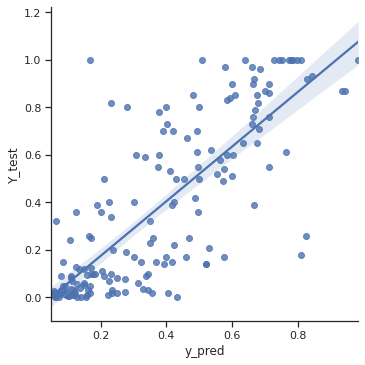

1
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
176
2-fold :  53.97727272727273
3-fold :  65.9090909090909
5-fold :  75.0
gmfe :  2.872012655226807
mfe :  1.2971984530751512
bias :  0.0417426951336862
rmse  0.2237756478006054
r2  0.541757187946257


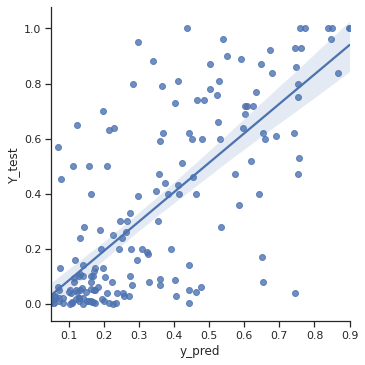

2
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
176
2-fold :  57.38636363636363
3-fold :  66.47727272727273
5-fold :  76.70454545454545
gmfe :  3.006859960222607
mfe :  1.2654450124476269
bias :  0.03891399872358475
rmse  0.21292726674250032
r2  0.6054578912841045


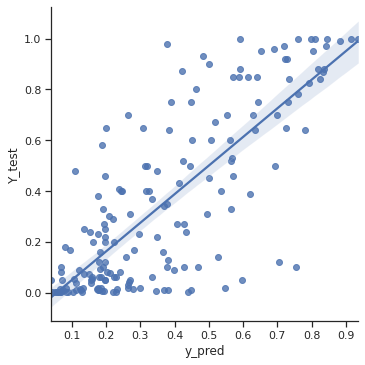

3
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
176
2-fold :  53.40909090909091
3-fold :  67.04545454545455
5-fold :  79.54545454545455
gmfe :  2.924550688074183
mfe :  1.2819487581274578
bias :  0.04100304608970294
rmse  0.2217086269455745
r2  0.6038337458792272


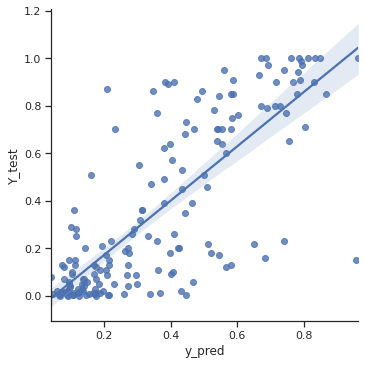

4
(704, 504)
(175, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
175
2-fold :  51.42857142857142
3-fold :  60.57142857142858
5-fold :  75.42857142857143
gmfe :  2.8559280164271783
mfe :  1.3112274572151668
bias :  0.05285921144813427
rmse  0.22063266496900338
r2  0.5531205853749244


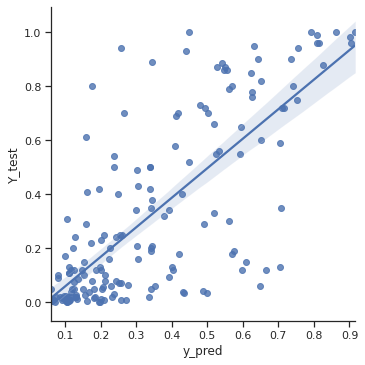

0
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
176
2-fold :  46.590909090909086
3-fold :  61.93181818181818
5-fold :  75.56818181818183
gmfe :  3.331033808689587
mfe :  1.4199470383236021
bias :  0.06878049647823511
rmse  0.22902854006428686
r2  0.4394013108768834


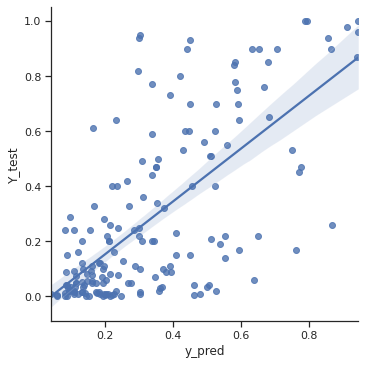

1
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
176
2-fold :  53.97727272727273
3-fold :  65.3409090909091
5-fold :  78.97727272727273
gmfe :  2.7240895662210924
mfe :  1.2862327940491676
bias :  0.027834875149032757
rmse  0.2399320022792722
r2  0.50253316157983


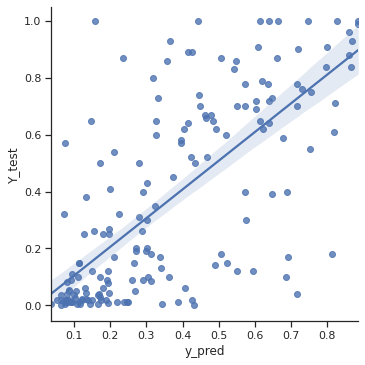

2
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
176
2-fold :  56.25
3-fold :  69.31818181818183
5-fold :  78.97727272727273
gmfe :  2.7619447263606505
mfe :  1.2907067980802884
bias :  0.022704332665760274
rmse  0.22012336707793823
r2  0.6168307335392968


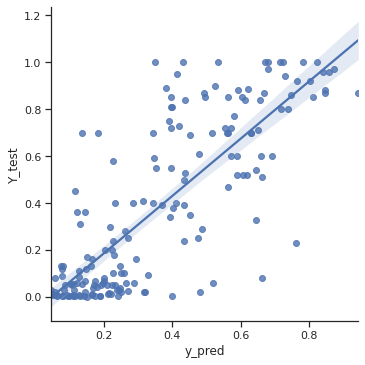

3
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
176
2-fold :  59.65909090909091
3-fold :  68.18181818181817
5-fold :  77.8409090909091
gmfe :  2.7126397592490195
mfe :  1.2467669265768988
bias :  0.05807942934289821
rmse  0.20425576077388452
r2  0.6331442402274574


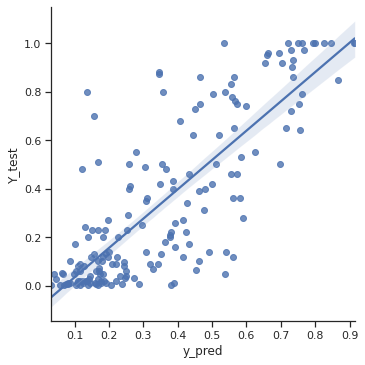

4
(704, 504)
(175, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
175
2-fold :  58.285714285714285
3-fold :  72.0
5-fold :  78.85714285714286
gmfe :  2.762354081819187
mfe :  1.2470111033203441
bias :  0.03698883632336186
rmse  0.20684561856255088
r2  0.656052573618326


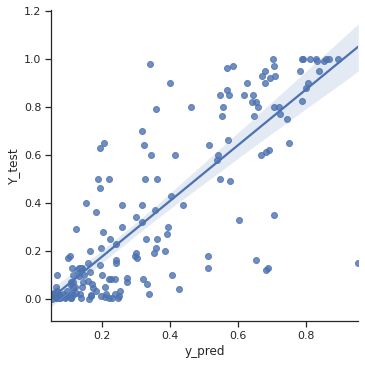

0
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  52.27272727272727
3-fold :  63.06818181818182
5-fold :  75.56818181818183
gmfe :  3.1156689082697526
mfe :  1.3237913615662447
bias :  0.058308835177696625
rmse  0.23095513848091181
r2  0.5639815558936963


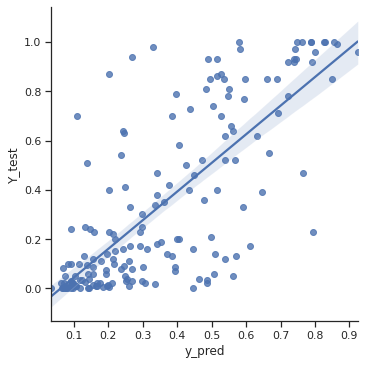

1
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  58.52272727272727
3-fold :  68.18181818181817
5-fold :  80.11363636363636
gmfe :  2.7273635870061654
mfe :  1.2655730774004186
bias :  0.01926714036406524
rmse  0.210872396514144
r2  0.5964175731655927


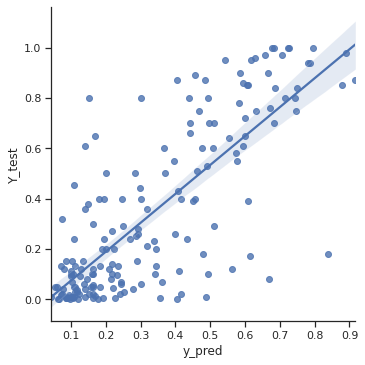

2
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
176
2-fold :  52.84090909090909
3-fold :  63.06818181818182
5-fold :  77.8409090909091
gmfe :  2.8109759020895653
mfe :  1.3111451643541872
bias :  0.05094428999229833
rmse  0.22503916919846004
r2  0.5774006336761481


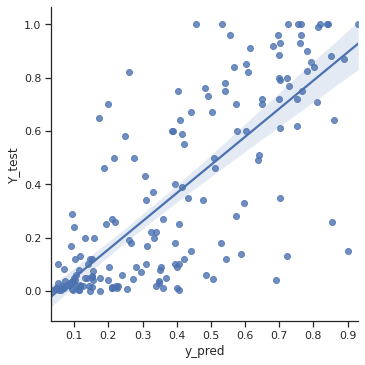

3
(703, 504)
(176, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  59.65909090909091
3-fold :  71.02272727272727
5-fold :  78.97727272727273
gmfe :  2.696413121982912
mfe :  1.251081411394434
bias :  0.031552927455809114
rmse  0.1930435663975007
r2  0.6549044937216106


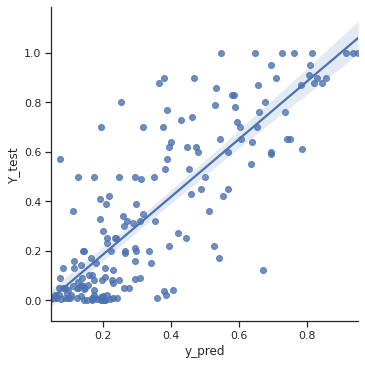

4
(704, 504)
(175, 504)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
175
2-fold :  52.0
3-fold :  64.0
5-fold :  75.42857142857143
gmfe :  2.8136867296615837
mfe :  1.2973316541823399
bias :  0.04769421159507282
rmse  0.2227358311918505
r2  0.5871214162098306


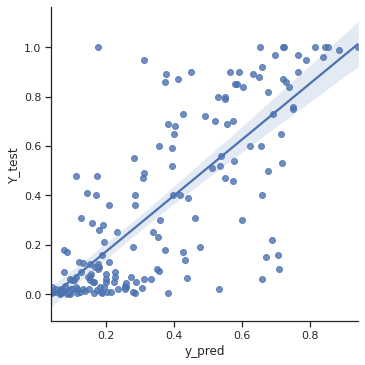

human_mrt
0
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
249
2-fold :  47.389558232931726
3-fold :  69.87951807228916
5-fold :  81.52610441767068
gmfe :  2.5525968255282727
mfe :  1.3922043279818226
bias :  0.05999224007512849
rmse  0.5433771421103982
r2  0.23262632048524923
saving model


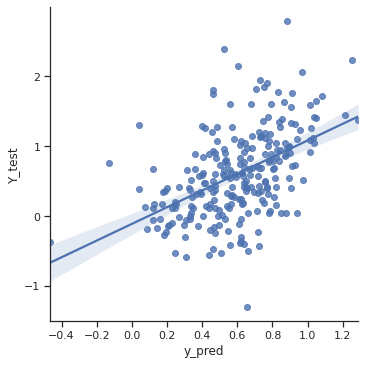

1
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
249
2-fold :  48.59437751004016
3-fold :  71.8875502008032
5-fold :  85.14056224899599
gmfe :  2.4906508165256267
mfe :  1.3676153830832307
bias :  -0.23263009371688215
rmse  0.5311989844959939
r2  0.22283489184336147
saving model


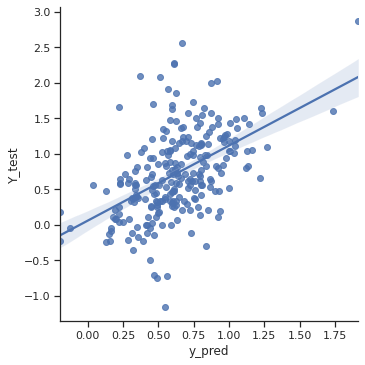

2
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
249
2-fold :  51.80722891566265
3-fold :  72.69076305220884
5-fold :  83.13253012048193
gmfe :  2.5670512606757456
mfe :  1.342015133328086
bias :  -0.15893604837721131
rmse  0.5658632877092341
r2  0.2689406675332974


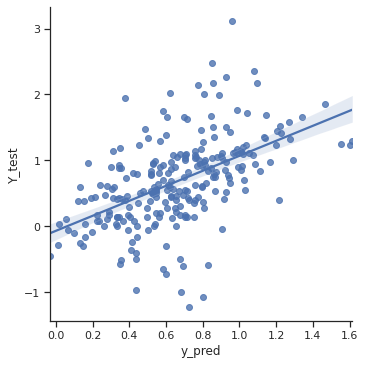

3
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
248
2-fold :  49.596774193548384
3-fold :  69.75806451612904
5-fold :  81.85483870967742
gmfe :  2.619065667988425
mfe :  1.3590216031065439
bias :  0.012358024924717048
rmse  0.5927821029648684
r2  0.2675697269692626


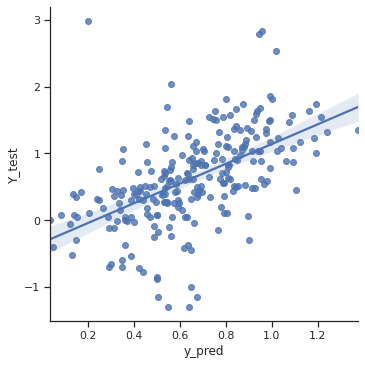

4
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
248
2-fold :  49.596774193548384
3-fold :  68.95161290322581
5-fold :  83.46774193548387
gmfe :  2.4804535418805225
mfe :  1.3575220471602156
bias :  0.5953007409317974
rmse  0.5303621435729136
r2  0.25991347775113793
saving model


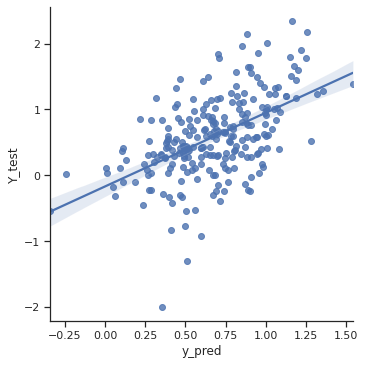

0
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
249
2-fold :  47.389558232931726
3-fold :  71.4859437751004
5-fold :  84.33734939759037
gmfe :  2.532850176073195
mfe :  1.3786055728372026
bias :  -0.20726279842127138
rmse  0.5495874656162708
r2  0.26665734120011764


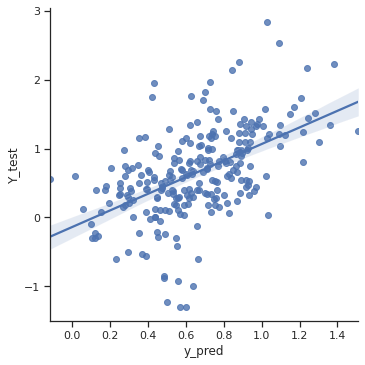

1
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=43)
249
2-fold :  45.78313253012048
3-fold :  67.8714859437751
5-fold :  78.714859437751
gmfe :  2.722240299402668
mfe :  1.3825567498939577
bias :  0.14115294894174912
rmse  0.5953990819315353
r2  0.2649597457901436


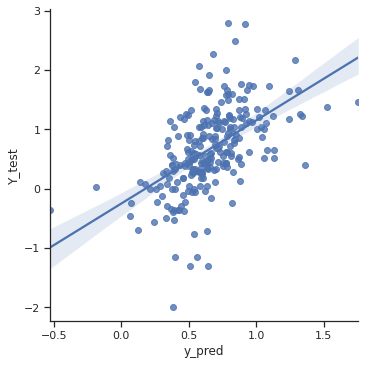

2
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
249
2-fold :  47.791164658634536
3-fold :  66.26506024096386
5-fold :  83.53413654618474
gmfe :  2.491729549238205
mfe :  1.3707123622646635
bias :  0.014780811371007063
rmse  0.5232637359671607
r2  0.2698919575259838


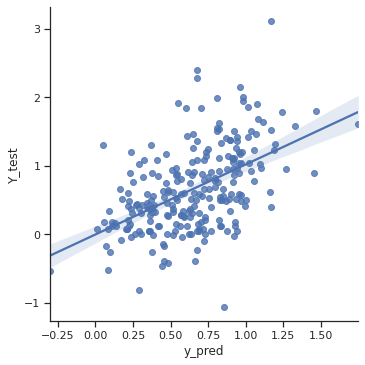

3
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
248
2-fold :  51.61290322580645
3-fold :  71.7741935483871
5-fold :  81.04838709677419
gmfe :  2.6068897220552425
mfe :  1.338120020090021
bias :  0.07488899911579294
rmse  0.5797491005097616
r2  0.22595222992646136


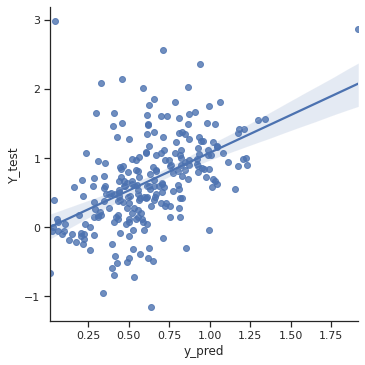

4
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
248
2-fold :  54.83870967741935
3-fold :  75.80645161290323
5-fold :  87.09677419354838
gmfe :  2.2603564675431063
mfe :  1.309407178957909
bias :  0.20352366582237968
rmse  0.4783359525773225
r2  0.35026217517660196
saving model


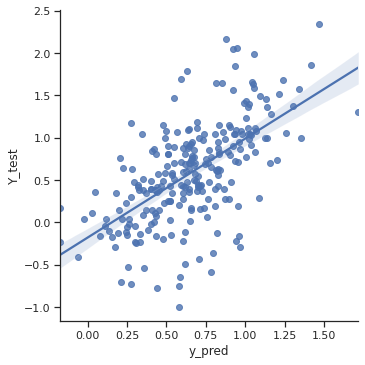

0
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  50.602409638554214
3-fold :  71.08433734939759
5-fold :  86.34538152610442
gmfe :  2.378670341030202
mfe :  1.350027475841925
bias :  0.03968029562089326
rmse  0.5057319392468146
r2  0.2733079510824472


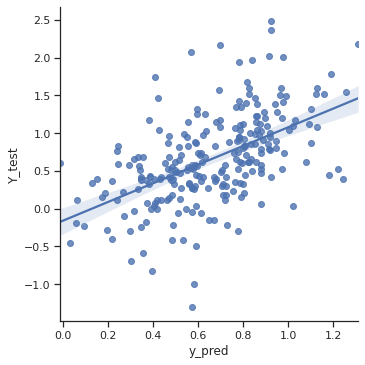

1
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
249
2-fold :  54.21686746987952
3-fold :  70.68273092369478
5-fold :  81.92771084337349
gmfe :  2.617373367750999
mfe :  1.3251303704116035
bias :  0.21031010350101997
rmse  0.5930346577602121
r2  0.26623774038820003


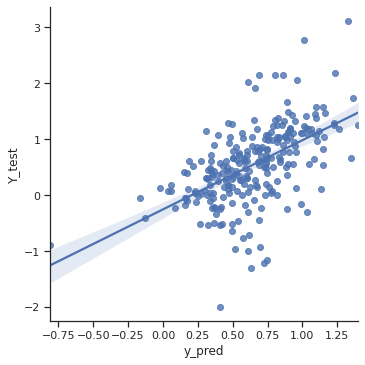

2
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=44)
249
2-fold :  47.791164658634536
3-fold :  71.08433734939759
5-fold :  83.93574297188755
gmfe :  2.4965468245411926
mfe :  1.37761486503614
bias :  0.09349083998796415
rmse  0.5290182009986056
r2  0.27756678928805434


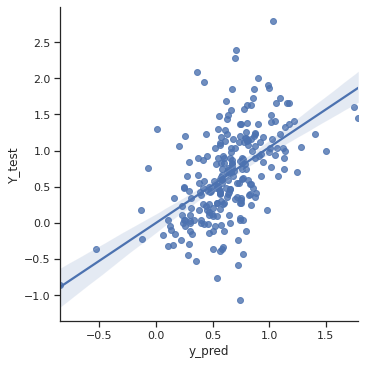

3
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
248
2-fold :  50.0
3-fold :  70.16129032258065
5-fold :  81.45161290322581
gmfe :  2.5206876889676266
mfe :  1.3540076188143404
bias :  0.17275736229925465
rmse  0.5445258482088807
r2  0.2428148022695017


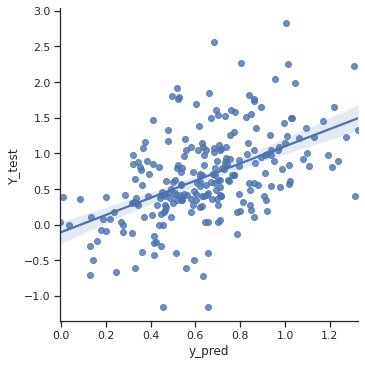

4
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
248
2-fold :  46.774193548387096
3-fold :  70.16129032258065
5-fold :  83.46774193548387
gmfe :  2.521000296012882
mfe :  1.369474137349504
bias :  -0.3070626652457049
rmse  0.5463367320163208
r2  0.31365737370393665


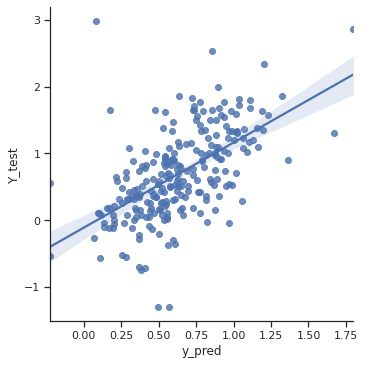

0
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
249
2-fold :  46.98795180722892
3-fold :  69.07630522088354
5-fold :  83.53413654618474
gmfe :  2.552235013361571
mfe :  1.3686634717188537
bias :  -0.490624071622646
rmse  0.5584381740695673
r2  0.22343403759151392


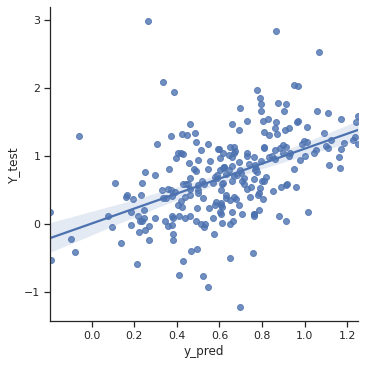

1
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
249
2-fold :  46.58634538152611
3-fold :  69.07630522088354
5-fold :  82.32931726907631
gmfe :  2.745447064525481
mfe :  1.3999991405048795
bias :  0.175675355121784
rmse  0.5994090092794813
r2  0.26450554090610123


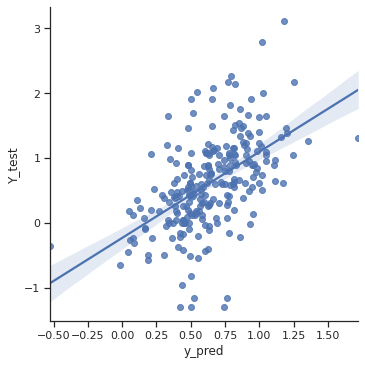

2
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
249
2-fold :  52.610441767068274
3-fold :  73.49397590361446
5-fold :  84.73895582329317
gmfe :  2.4236376499650385
mfe :  1.3356038952659675
bias :  -0.05652772220481772
rmse  0.5300308683524136
r2  0.30298384498103925


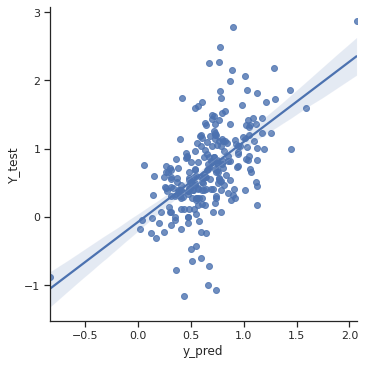

3
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
248
2-fold :  48.38709677419355
3-fold :  72.58064516129032
5-fold :  84.2741935483871
gmfe :  2.3958554699824486
mfe :  1.3764548745759995
bias :  -0.011179057223209332
rmse  0.4971075610187532
r2  0.3198816887508297


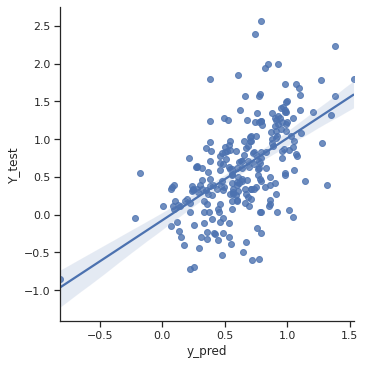

4
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
248
2-fold :  50.0
3-fold :  69.75806451612904
5-fold :  82.25806451612904
gmfe :  2.5125468897381884
mfe :  1.3522807143200062
bias :  0.6328377470710225
rmse  0.5393846548740678
r2  0.2535486041114896


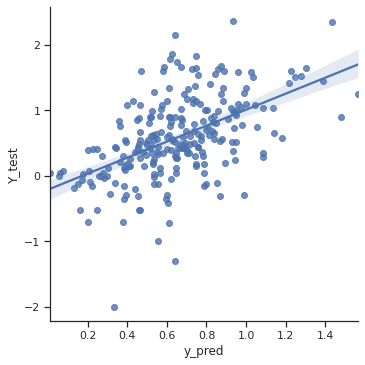

0
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=46)
249
2-fold :  45.38152610441767
3-fold :  68.67469879518072
5-fold :  81.12449799196787
gmfe :  2.6413058012253843
mfe :  1.3874741486799402
bias :  0.10990702659787344
rmse  0.5599141574192776
r2  0.3055411883974831


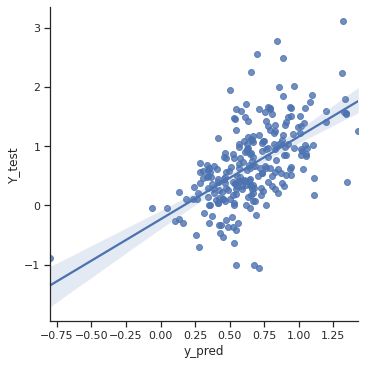

1
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
249
2-fold :  50.20080321285141
3-fold :  71.8875502008032
5-fold :  83.93574297188755
gmfe :  2.410379929911615
mfe :  1.3502091930369193
bias :  -0.05851040413496289
rmse  0.5145808030010731
r2  0.31873385576775015


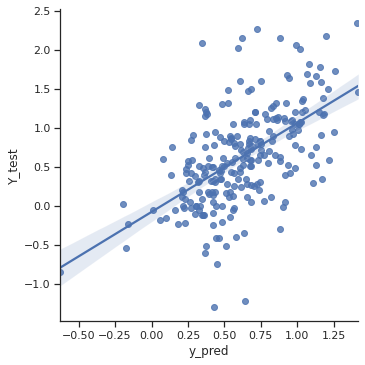

2
(994, 504)
(249, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
249
2-fold :  54.21686746987952
3-fold :  75.50200803212851
5-fold :  85.54216867469879
gmfe :  2.3193321586337747
mfe :  1.326597050233044
bias :  -0.0437790170058987
rmse  0.5014628781672565
r2  0.3221125444002475


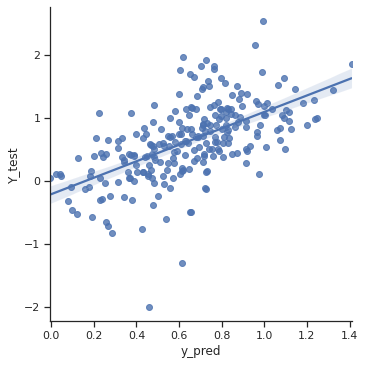

3
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
248
2-fold :  46.774193548387096
3-fold :  65.32258064516128
5-fold :  80.64516129032258
gmfe :  2.840648260900813
mfe :  1.4197701061664634
bias :  -0.0706348449313281
rmse  0.6268658210894525
r2  0.16408993452956744


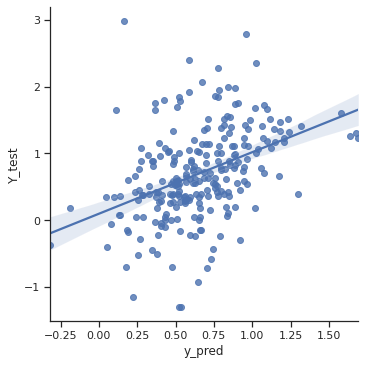

4
(995, 504)
(248, 504)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
248
2-fold :  47.58064516129033
3-fold :  72.58064516129032
5-fold :  84.67741935483872
gmfe :  2.4189534876155037
mfe :  1.3899507871015073
bias :  0.34311180957559756
rmse  0.5086536365913618
r2  0.2969659559304444


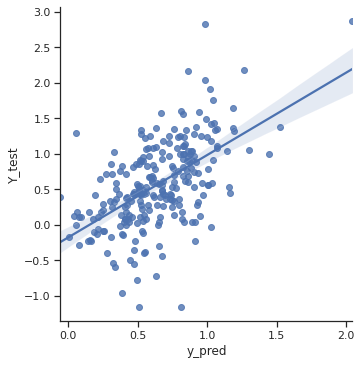

human_thalf
0
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  45.45454545454545
3-fold :  67.98418972332016
5-fold :  84.58498023715416
gmfe :  2.550459083235189
mfe :  1.4044614449198154
bias :  -0.18579615396230809
rmse  0.5270765840483957
r2  0.29479903694024256
saving model


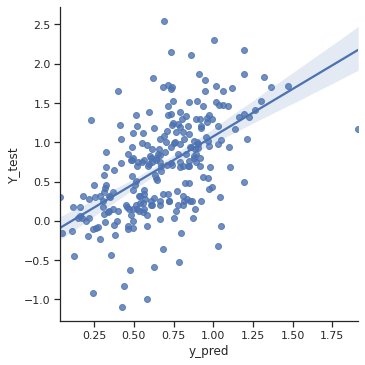

1
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  51.38339920948617
3-fold :  69.56521739130434
5-fold :  84.58498023715416
gmfe :  2.457448177260202
mfe :  1.336015877958564
bias :  0.3889265153597088
rmse  0.5288791655133237
r2  0.2762562210047875
saving model


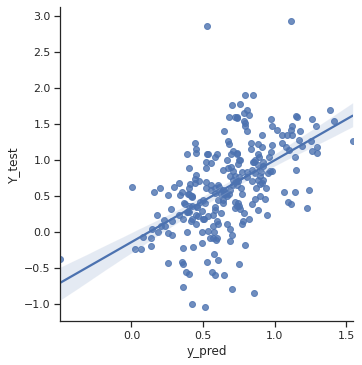

2
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
253
2-fold :  54.1501976284585
3-fold :  73.51778656126481
5-fold :  86.56126482213439
gmfe :  2.326401102927603
mfe :  1.308767815848968
bias :  0.13871039192777834
rmse  0.4878571743307487
r2  0.30070844999664426
saving model


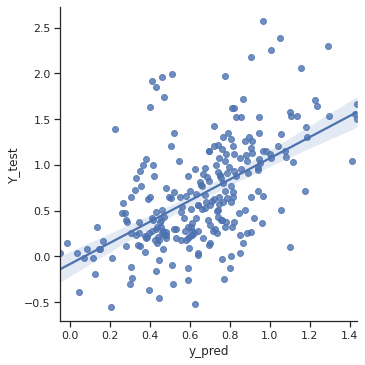

3
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  46.6403162055336
3-fold :  68.37944664031622
5-fold :  82.21343873517787
gmfe :  2.7183106396871097
mfe :  1.373103396971728
bias :  0.2935176492700693
rmse  0.5988769222560194
r2  0.2666461666458426


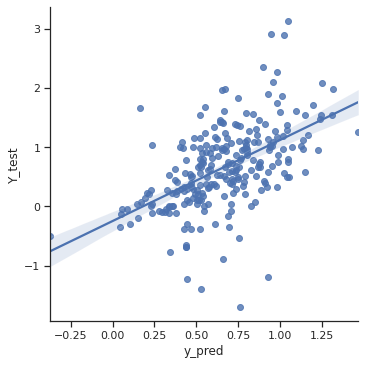

4
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
253
2-fold :  52.17391304347826
3-fold :  75.09881422924902
5-fold :  88.93280632411067
gmfe :  2.178369872776973
mfe :  1.3378757740982843
bias :  0.21322996765620106
rmse  0.45760439276249437
r2  0.36107783541057603
saving model


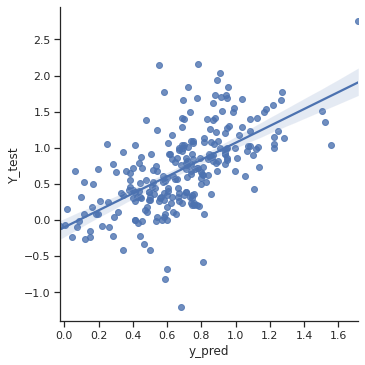

0
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  47.43083003952569
3-fold :  72.72727272727273
5-fold :  90.11857707509881
gmfe :  2.2745326287357126
mfe :  1.375034311232788
bias :  -0.04819007668241104
rmse  0.46287445843888764
r2  0.32649094410269675


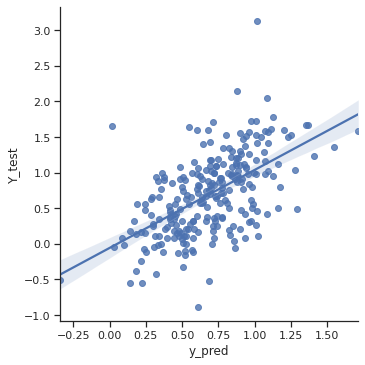

1
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
253
2-fold :  52.17391304347826
3-fold :  69.96047430830039
5-fold :  80.63241106719367
gmfe :  2.62817923379755
mfe :  1.336401873435585
bias :  0.6235390956377191
rmse  0.580539353699898
r2  0.2423457197830976


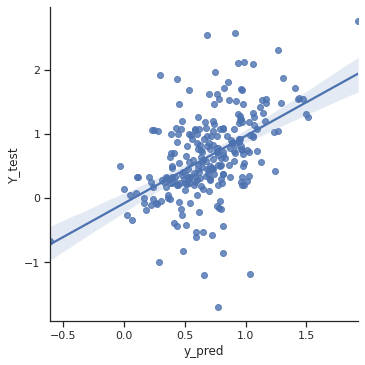

2
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  50.988142292490124
3-fold :  66.79841897233202
5-fold :  85.7707509881423
gmfe :  2.468269173189091
mfe :  1.3363514924011632
bias :  0.06802585215956292
rmse  0.5237173927406729
r2  0.2570092092797218


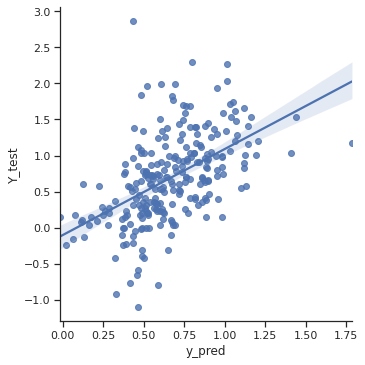

3
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
253
2-fold :  47.43083003952569
3-fold :  69.1699604743083
5-fold :  84.58498023715416
gmfe :  2.4775881068272403
mfe :  1.371457840489013
bias :  0.019510904481412794
rmse  0.5199472295663298
r2  0.2946013839870557


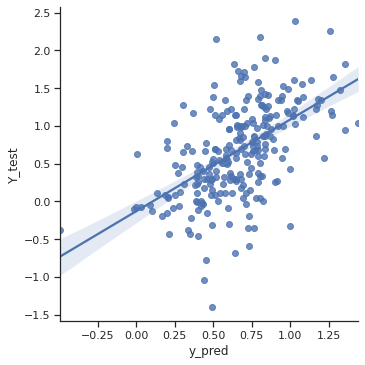

4
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  53.359683794466406
3-fold :  72.72727272727273
5-fold :  85.37549407114624
gmfe :  2.4550678811324107
mfe :  1.319844939099594
bias :  0.3315219522536619
rmse  0.5324131008966866
r2  0.3306497095858578


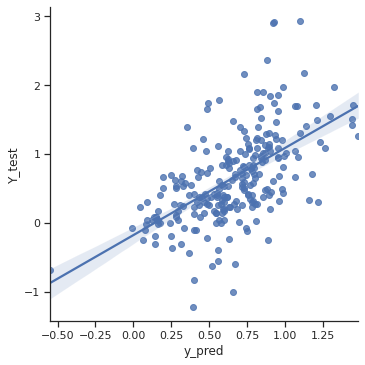

0
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=44)
253
2-fold :  52.569169960474305
3-fold :  77.86561264822134
5-fold :  88.93280632411067
gmfe :  2.216365018683096
mfe :  1.3358180310148389
bias :  0.14915860293513505
rmse  0.45740433435428285
r2  0.3534802415275726


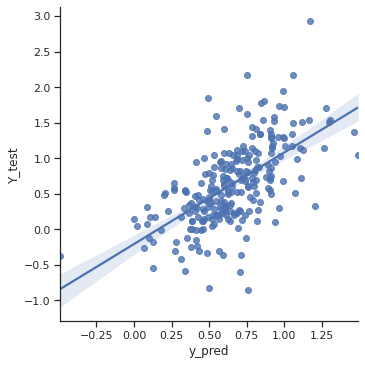

1
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
253
2-fold :  47.82608695652174
3-fold :  69.1699604743083
5-fold :  85.37549407114624
gmfe :  2.5277461186901258
mfe :  1.377381143525886
bias :  0.17819578721803064
rmse  0.5409435127494542
r2  0.30426482568090285


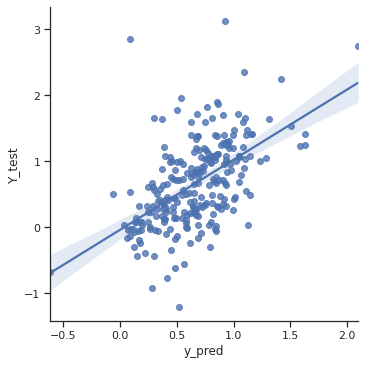

2
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
253
2-fold :  52.17391304347826
3-fold :  71.93675889328063
5-fold :  88.93280632411067
gmfe :  2.3800198481008445
mfe :  1.326528222691536
bias :  0.31804640961505437
rmse  0.49997515790610025
r2  0.30483643844922925


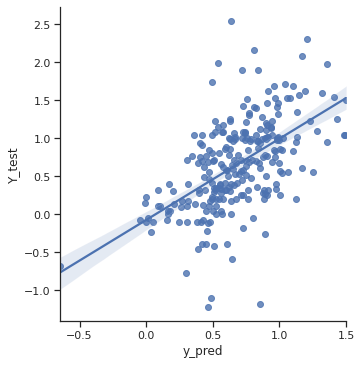

3
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
253
2-fold :  49.01185770750988
3-fold :  67.58893280632411
5-fold :  83.00395256916995
gmfe :  2.6400763355493866
mfe :  1.3761745959475256
bias :  0.5440450948002558
rmse  0.5655818991057359
r2  0.26572991760524567


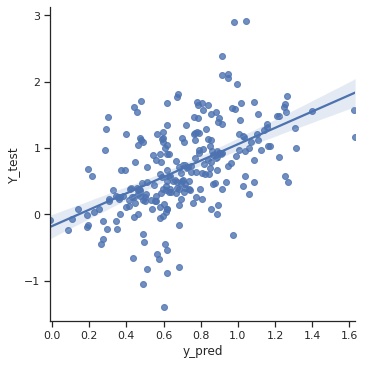

4
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
253
2-fold :  50.19762845849802
3-fold :  70.7509881422925
5-fold :  85.37549407114624
gmfe :  2.5254906961023345
mfe :  1.349122039695032
bias :  -0.10144863268821869
rmse  0.5524334848728258
r2  0.23291275156004332


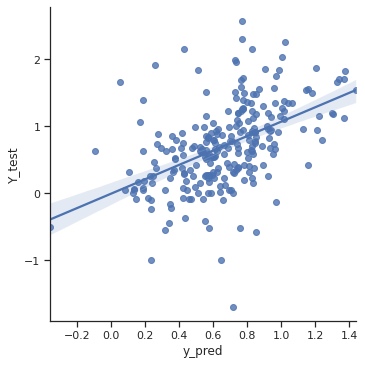

0
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
253
2-fold :  46.6403162055336
3-fold :  68.77470355731225
5-fold :  84.58498023715416
gmfe :  2.588689722823838
mfe :  1.38697878807778
bias :  0.36378812372184033
rmse  0.5470209572999126
r2  0.23417195936878743


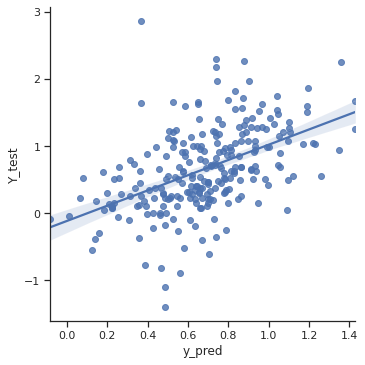

1
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
253
2-fold :  50.988142292490124
3-fold :  72.33201581027669
5-fold :  88.53754940711462
gmfe :  2.283091793590067
mfe :  1.3347246896680478
bias :  0.13378174483473115
rmse  0.46728745844750574
r2  0.32987962004778826


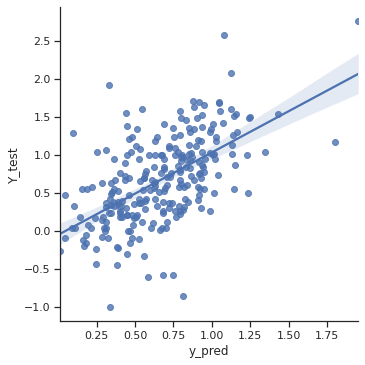

2
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
253
2-fold :  51.38339920948617
3-fold :  72.33201581027669
5-fold :  85.37549407114624
gmfe :  2.4769191410430897
mfe :  1.3383348030031401
bias :  -0.19116987222232573
rmse  0.5508766019120428
r2  0.2668039846919015


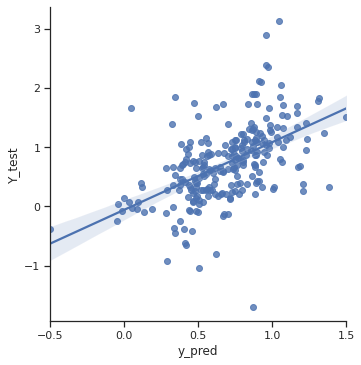

3
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  50.59288537549407
3-fold :  70.35573122529645
5-fold :  83.00395256916995
gmfe :  2.5392261078204856
mfe :  1.340932236288321
bias :  0.36881528473398895
rmse  0.5432087786976169
r2  0.2978468342686552


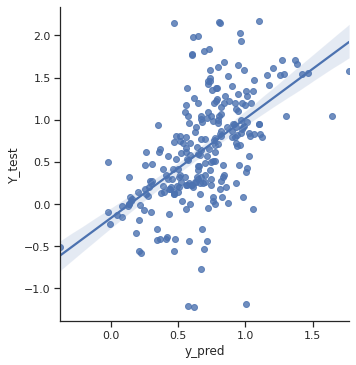

4
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  49.01185770750988
3-fold :  72.72727272727273
5-fold :  86.95652173913044
gmfe :  2.370351704985106
mfe :  1.3625729162720863
bias :  0.2241165879211905
rmse  0.5032318943676377
r2  0.3440276504433629


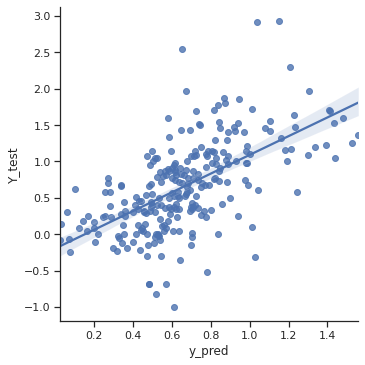

0
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
253
2-fold :  44.66403162055336
3-fold :  67.58893280632411
5-fold :  85.37549407114624
gmfe :  2.5944017544517495
mfe :  1.3981393937023177
bias :  -0.21583857983178234
rmse  0.554539726306439
r2  0.19274881886521755


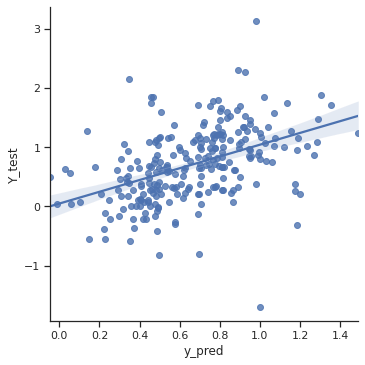

1
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  52.17391304347826
3-fold :  75.8893280632411
5-fold :  88.93280632411067
gmfe :  2.252889838523636
mfe :  1.3346061823856148
bias :  0.15990347465779653
rmse  0.4656768645225753
r2  0.3264065965354258


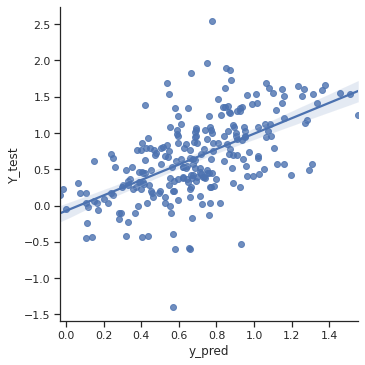

2
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
253
2-fold :  50.988142292490124
3-fold :  72.33201581027669
5-fold :  84.18972332015811
gmfe :  2.4050315019394195
mfe :  1.3432106862815856
bias :  0.20662493925071468
rmse  0.5122035872569664
r2  0.2854065054022583


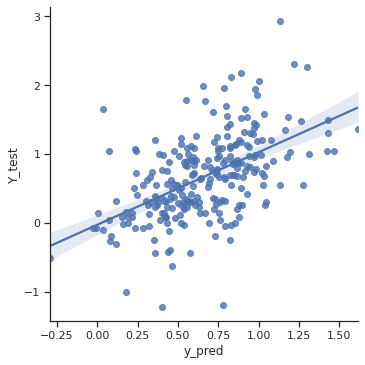

3
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  48.616600790513836
3-fold :  68.77470355731225
5-fold :  83.399209486166
gmfe :  2.583148184386819
mfe :  1.3654190178737093
bias :  0.416387022603554
rmse  0.5572789078425966
r2  0.3315697857616746


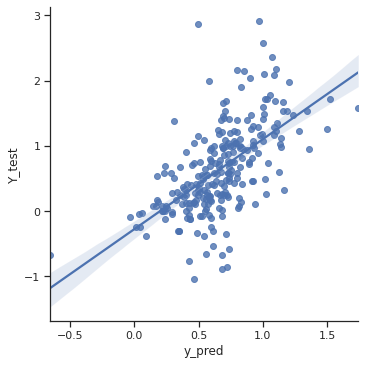

4
(1012, 504)
(253, 504)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
253
2-fold :  51.38339920948617
3-fold :  71.14624505928853
5-fold :  85.7707509881423
gmfe :  2.4240560133867093
mfe :  1.3371494022139807
bias :  0.04324859795812852
rmse  0.5207998467199741
r2  0.3288360273412344


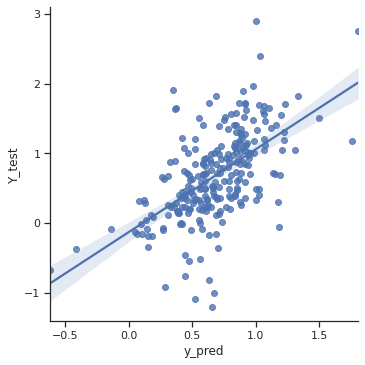

In [21]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    #log human_VDss_L_kg model
    data = human_lombardo_mfp_Mordred
    features = features_mfp_mordred_columns
    baseline=10

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features) 

    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_mfp_mrd_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])

In [22]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           300         sqrt   
1    human_VDss_L_kg            42      1           300         sqrt   
2    human_VDss_L_kg            42      2           100         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           300         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           100         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           200         sqrt   
123      human_thalf            46      3           300         sqrt   
124      human_thalf            46      4           300         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    2         15      False  
1                    2         15      False  
2                    4         15      False  
3                    2         15      False  
4                    4         15      False  
..                 ...        ...        ...  
120                  4         15      False  
121                  2         15      False  
122                  4         15      False  
123                  2         15      False  
124                  4         15      False  

[125 rows x 8 columns]

In [23]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                            "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.195429  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.067789 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.722590 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.352938  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c... -0.062127  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  1.023258  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.524247  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.633499 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.565308  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.917900  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [24]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  54.000000  75.600000   
1    HeldOut  human_VDss_L_kg            42      1  59.600000  76.000000   
2    HeldOut  human_VDss_L_kg            42      2  54.400000  74.000000   
3    HeldOut  human_VDss_L_kg            42      3  59.600000  72.800000   
4    HeldOut  human_VDss_L_kg            42      4  53.012048  74.297189   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  44.664032  67.588933   
121  HeldOut      human_thalf            46      1  52.173913  75.889328   
122  HeldOut      human_thalf            46      2  50.988142  72.332016   
123  HeldOut      human_thalf            46      3  48.616601  68.774704   
124  HeldOut      human_thalf            46      4  51.383399  71.146245   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    88.400000  2.185996  1.296509  0.021021  0.450931  0.528726  
1    89.200000  2.070795  1.257176  0.079948  0.414424  0.539975  
2    86.400000  2.233725  1.297098  0.009445  0.481529  0.466199  
3    88.000000  2.114939  1.263085  0.015340  0.430800  0.556857  
4    90.361446  2.221393  1.311539  0.071420  0.454013  0.465747  
..         ...       ...       ...       ...       ...       ...  
120  85.375494  2.594402  1.398139 -0.215839  0.554540  0.192749  
121  88.932806  2.252890  1.334606  0.159903  0.465677  0.326407  
122  84.189723  2.405032  1.343211  0.206625  0.512204  0.285407  
123  83.399209  2.583148  1.365419  0.416387  0.557279  0.331570  
124  85.770751  2.424056  1.337149  0.043249  0.520800  0.328836  

[125 rows x 12 columns]

In [25]:
detail_list.to_csv("detail_list_Prediction_human_from_mordred_morgan_fs.csv", index=False)

In [26]:
model_parameters.to_csv("model_parameters_Prediction_human_from_mordred_morgan_fs.csv", index=False)

In [27]:
results.to_csv("Prediction_human_from_mordred_morgan_fs.csv", index=False)

In [28]:
#OLD RESULTS

import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_mordred_morgan.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  49.758208  69.976289  84.620927   
human_VDss_L_kg             44.0    2.0  56.589622  74.812851  89.064482   
human_fup                   44.0    2.0  54.744026  66.097403  77.655455   
human_mrt                   44.0    2.0  49.300428  70.699896  83.201645   
human_thalf                 44.0    2.0  49.976285  71.019763  85.644269   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.517182  1.351023 -0.256979  0.545719  0.287899  
human_VDss_L_kg     2.153774  1.286130  0.033112  0.442679  0.519300  
human_fup           2.858954  1.292357  0.041929  0.219733  0.579648  
human_mrt           2.524740  1.363242  0.049705  0.545777  0.271000  
human_thalf         2.453685  1.352256  0.177626  0.522330  0.293980

In [29]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_mordred_morgan.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  49.758208  69.976289  84.620927   
human_VDss_L_kg             44.0    2.0  56.589622  74.812851  89.064482   
human_fup                   44.0    2.0  54.744026  66.097403  77.655455   
human_mrt                   44.0    2.0  49.300428  70.699896  83.201645   
human_thalf                 44.0    2.0  49.976285  71.019763  85.644269   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.517182  1.351023 -0.256979  0.545719  0.287899  
human_VDss_L_kg     2.153774  1.286130  0.033112  0.442679  0.519300  
human_fup           2.858954  1.292357  0.041929  0.219733  0.579648  
human_mrt           2.524740  1.363242  0.049705  0.545777  0.271000  
human_thalf         2.453685  1.352256  0.177626  0.522330  0.293980

In [30]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_mfp_mrd_model.sav", 'rb'))

In [31]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)

In [33]:
import pickle
list_of_lists=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred
    features = features_mfp_mordred_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features) 
    
    # Save the scaler to a file
    with open(f'mfp_mrd_{endpoint}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)
        
    X = df[features]
    Y = df[endpoint]

    X_train= X.values
    Y_train= Y.values.flatten()

    print(X_train.shape)
    print(X_test.shape)

          
    loaded_rf = pickle.load(open(f"log_{endpoint}_mfp_mrd_model.sav", 'rb'))
    params = loaded_rf.get_params()
    
    classifier= RandomForestRegressor(**params)
    classifier.fit(X_train, Y_train)
    
    pickle.dump(classifier, open(f"log_{endpoint}_WITHOUTanimaldata_artificial_model_FINAL.sav", 'wb'))

human_VDss_L_kg
(1249, 504)
(253, 504)
human_CL_mL_min_kg
(1281, 504)
(253, 504)
human_fup
(879, 504)
(253, 504)
human_mrt
(1243, 504)
(253, 504)
human_thalf
(1265, 504)
(253, 504)
